# Install the library and download the necessary file

## Installation of Required Libraries

To ensure that you have all the required libraries, run the following installation commands. Each command installs a specific library and its dependencies.


In [ ]:
!pip install pytorch_lightning==2.1.3
!pip install umap==0.1.1
!pip install scanpy==1.9.6
!pip install scvelo==0.3.1
!pip install python-igraph==0.11.3
!pip install tslearn==0.6.3
!pip install scikit-learn==1.1.3

If you want to copy the necessary files using Google Colab, run the cell below.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp -av "/content/drive/MyDrive/student_majima/Data/20230223Larry_adata.h5ad" "/content/"
!cp -av "/content/drive/MyDrive/student_majima/Data/20230413_total_adata.h5ad" "/content/"
!cp -av "/content/drive/MyDrive/student_majima/Data/processed_iep_hf1_reaggr.h5ad" "/content/"
!cp -av "/content/drive/MyDrive/student_majima/Data/total_z.csv" "/content/"
!cp -av "/content/drive/MyDrive/student_majima/Data/z_series.csv" "/content/"
!cp -av "/content/drive/MyDrive/student_majima/Data/inf_adata_obs.csv" "/content/"
!cp -av "/content/drive/MyDrive/student_majima/Data/inf_adata_var.csv" "/content/"
!cp -av "/content/drive/MyDrive/student_majima/Data/PanglaoDB.csv" "/content/"
!cp -av "/content/drive/MyDrive/student_majima/Data/tf_target.txt"  "/content/"

'/content/drive/MyDrive/student_majima/Data/20230223Larry_adata.h5ad' -> '/content/20230223Larry_adata.h5ad'
'/content/drive/MyDrive/student_majima/Data/20230413_total_adata.h5ad' -> '/content/20230413_total_adata.h5ad'
'/content/drive/MyDrive/student_majima/Data/processed_iep_hf1_reaggr.h5ad' -> '/content/processed_iep_hf1_reaggr.h5ad'
'/content/drive/MyDrive/student_majima/Data/total_z.csv' -> '/content/total_z.csv'
'/content/drive/MyDrive/student_majima/Data/z_series.csv' -> '/content/z_series.csv'
'/content/drive/MyDrive/student_majima/Data/inf_adata_obs.csv' -> '/content/inf_adata_obs.csv'
'/content/drive/MyDrive/student_majima/Data/inf_adata_var.csv' -> '/content/inf_adata_var.csv'
'/content/drive/MyDrive/student_majima/Data/PanglaoDB.csv' -> '/content/PanglaoDB.csv'
'/content/drive/MyDrive/student_majima/Data/tf_target.txt' -> '/content/tf_target.txt'


In [4]:
!cp -av "/content/drive/MyDrive/student_majima/Data/20231123_hematopoiesis/202311231230_model_parameters.pth" "/content/"
!cp -av "/content/drive/MyDrive/student_majima/Data/20231123_hematopoiesis/202312161002_select_adata.h5ad" "/content/"
!cp -av "/content/drive/MyDrive/student_majima/Data/20231123_hematopoiesis/202311231230_var_list.csv" "/content/"
!cp -av "/content/drive/MyDrive/student_majima/Data/20231123_hematopoiesis/202312190720_trans.joblib" "/content/"
!cp -av "/content/drive/MyDrive/student_majima/Data/20231123_hematopoiesis/202311231442_inf_adata.h5ad" "/content/"
!cp -av "/content/drive/MyDrive/student_majima/Data/20231123_hematopoiesis/202401121044_check_adata.h5ad" "/content/"

'/content/drive/MyDrive/student_majima/Data/20231123_hematopoiesis/202311231230_model_parameters.pth' -> '/content/202311231230_model_parameters.pth'
cp: cannot stat '/content/drive/MyDrive/student_majima/Data/20231123_hematopoiesis/202312161002_select_adata.h5ad': No such file or directory
'/content/drive/MyDrive/student_majima/Data/20231123_hematopoiesis/202311231230_var_list.csv' -> '/content/202311231230_var_list.csv'
'/content/drive/MyDrive/student_majima/Data/20231123_hematopoiesis/202312190720_trans.joblib' -> '/content/202312190720_trans.joblib'
'/content/drive/MyDrive/student_majima/Data/20231123_hematopoiesis/202311231442_inf_adata.h5ad' -> '/content/202311231442_inf_adata.h5ad'
'/content/drive/MyDrive/student_majima/Data/20231123_hematopoiesis/202401121044_check_adata.h5ad' -> '/content/202401121044_check_adata.h5ad'


# Define data processing and training functions

In the GitHub repository, the code for LineageVAE is organized into separate `.py` files for better modularity and maintenance. However, to make it easier to follow along in this tutorial, we have consolidated the code into a single notebook. Each of the following cells corresponds to one of the original `.py` files.

### 1 of 5: dataset.py

In this first cell, we include the code from `dataset.py`. This section contains essential functions for handling and preprocessing the data required by LineageVAE. The functions in this cell help in selecting cells from each lineage that include cells observed in the first observation time point, preprocessing, and organizing the data into the appropriate format for further analysis.


In [ ]:
import random
import torch
import pandas as pd
import scanpy as sc
import numpy as np
import anndata

def select_anndata(adata, batch_size=20):

    selected_cells = []

    lineage_counts = adata.obs['Lineage'].value_counts()
    lineage_with_30_cells = lineage_counts[lineage_counts >= batch_size].index

    selected_lineages = []
    for lineage in lineage_with_30_cells:
        if any(adata.obs['Day'][adata.obs['Lineage'] == lineage] == 2):
            selected_lineages.append(lineage)

    for lineage in selected_lineages:
        selected_batch_cells = []
        cells_with_day2 = adata.obs.index[(adata.obs['Lineage'] == lineage) & (adata.obs['Day'] == 2)]
        if len(cells_with_day2) > 0:
            selected_day2_cell = random.choice(cells_with_day2)
            selected_batch_cells.append(selected_day2_cell)


        cells_in_lineage = adata.obs.index[(adata.obs['Lineage'] == lineage)]
        cells_in_lineage = cells_in_lineage[cells_in_lineage != selected_day2_cell]
        rest_of_batch_cells = random.sample(cells_in_lineage.tolist(), (int(batch_size) - 1))
        selected_batch_cells.extend(rest_of_batch_cells)

        if len(selected_batch_cells) == batch_size:
            selected_cells.extend(selected_batch_cells)
        else:
            print('lineage number error')
            print(len(selected_batch_cells))

    selected_adata = adata[selected_cells]

    return(selected_adata)


def heldout_anndata(adata, batch_size=20):

    selected_cells = []
    rest_of_cells = []
    selected_lineages = []
    for lineage in adata.obs['Lineage'].unique():
        lineage_cells = adata.obs.index[adata.obs['Lineage'] == lineage]

        if any(adata.obs['Day'][lineage_cells] == 2):
            day2_cells = lineage_cells[adata.obs['Day'][lineage_cells] == 2]
            day6_cells = lineage_cells[adata.obs['Day'][lineage_cells] == 6]

            if len(day2_cells)+len(day6_cells) > batch_size:
                selected_lineages.append(lineage)


    for lineage in selected_lineages:
        selected_batch_cells = []
        cells_with_day2 = adata.obs.index[(adata.obs['Lineage'] == lineage) & (adata.obs['Day'] == 2)]
        if len(cells_with_day2) > 0:
            selected_day2_cell = random.choice(cells_with_day2)
            selected_batch_cells.append(selected_day2_cell)

        cells_in_lineage = adata.obs.index[(adata.obs['Lineage'] == lineage) & ((adata.obs['Day'] == 2) | (adata.obs['Day'] == 6))]
        cells_in_lineage = cells_in_lineage[cells_in_lineage != selected_day2_cell]
        rest_of_batch_cells = random.sample(cells_in_lineage.tolist(), (int(batch_size) - 1))
        selected_batch_cells.extend(rest_of_batch_cells)

        if len(selected_batch_cells) == batch_size:
            selected_cells.extend(selected_batch_cells)

    heldout_adata = adata[selected_cells]

    for lineage in selected_lineages:
        selected_batch_cells = []
        cells_day4 = adata.obs.index[(adata.obs['Lineage'] == lineage) & (adata.obs['Day'] == 4)]
        rest_of_cells.extend(cells_day4)

    rest_of_adata = adata[rest_of_cells]

    return(heldout_adata, rest_of_adata)


def anndata_preprocessing(adata, n_top_genes=None, min_genes=None, target_sum=None):
    """
    Preprocesses AnnData object based on provided parameters.

    Parameters:
        adata (AnnData): Annotated data matrix with cells as rows and features as columns.
        n_top_genes (int or None): Number of highly variable genes to select.
        min_genes (int or None): Minimum number of genes expressed in cells to retain a cell.

    Returns:
        None (Modifies the input AnnData object in place)
    """
    adata = adata[~adata.obs['Day'].isna()] # Drop NaN
    sc.pp.log1p(adata) # logarization
    if n_top_genes is not None:
        sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes)
    else:
        sc.pp.highly_variable_genes(adata)
    sc.pl.highly_variable_genes(adata)
    if min_genes is not None:
        sc.pp.filter_cells(adata, min_genes=min_genes)
    else:
        sc.pp.filter_cells(adata) # Exclude cells expressing too few genes
    if target_sum is not None:
        sc.pp.normalize_total(adata, target_sum=target_sum)
    else:
        sc.pp.normalize_total(adata) # Normalization

    return(adata)


def extract_highly_variable_genes(adata):
    var_list = []
    for i, is_highly_variable in enumerate(adata.var['highly_variable']):
        if is_highly_variable:
            var_list.append(adata.var.index[i])
    return var_list


def select_dataset(adata, batch_size):

    lineage_counts = adata.obs['Lineage'].value_counts()
    lineage_with_30_cells = lineage_counts[lineage_counts >= batch_size].index
    selected_adata = []
    for lineage in lineage_with_30_cells:
        lineage_cells = adata[adata.obs['Lineage'] == lineage]
        days = np.unique(lineage_cells.obs['Day'])
        selected_cells = []
        selected_days = set()

        for day in days:
            day_cells = lineage_cells[lineage_cells.obs['Day'] == day]
            random_cell_idx = np.random.choice(len(day_cells), size=1, replace=False)[0]
            selected_cells.extend(day_cells[random_cell_idx])
            selected_days.add(day)

            if len(selected_cells) >= batch_size:
                break

            if len(selected_days) == len(days):
                break

        if len(selected_cells) < batch_size:
            additional_cells_needed = batch_size - len(selected_cells)
            selected_cell_identifiers = [cell.obs_names[0] for cell in selected_cells]
            remaining_cells = [cell for cell in lineage_cells if cell.obs_names[0] not in selected_cell_identifiers]
            remaining_cells = anndata.concat(remaining_cells)
            additional_cells_idx = np.random.choice(len(remaining_cells), size=additional_cells_needed, replace=False)[0:additional_cells_needed]
            additional_cells = remaining_cells[additional_cells_idx]
            selected_cells.extend(additional_cells)

        selected_cells = anndata.concat(selected_cells)
        selected_adata.append(selected_cells)

    return(selected_adata)


def select_undifferentiated_anndata(adata, selected_adata, undifferentiated_cell_size, initial=False):
    undifferentiated_sample_list = []
    subgroup_indices = np.where((adata.obs['Day'] == 0) | (adata.obs['Day'] == 6))[0]
    subgroup_adata = adata[subgroup_indices]

    if initial:
        for i in range(len(selected_adata)):
            initial_cell_index = random.choice(adata[adata.obs['Day'] == 0].obs.index)
            additional_cells = adata[initial_cell_index]
            undifferentiated_cell_size_i = undifferentiated_cell_size - len(additional_cells)
            selected_cell_identifiers = [cell.obs_names[0] for cell in undifferentiated_sample_list]
            remaining_cells = [cell for cell in subgroup_adata if cell.obs_names[0] not in selected_cell_identifiers]
            remaining_cells = anndata.concat(remaining_cells)
            additional_cells_idx = np.random.choice(len(remaining_cells), size=undifferentiated_cell_size_i, replace=False)[0:undifferentiated_cell_size_i]
            additional_cells = anndata.concat([additional_cells, remaining_cells[additional_cells_idx]])
            additional_cells = anndata.concat(additional_cells)
            undifferentiated_sample_list.append(additional_cells)

        initial_cells_idx = np.where(subgroup_adata.obs['Day'] == 0)[0]
        initial_cells = subgroup_adata[initial_cells_idx]
        undifferentiated_sample_list.append(initial_cells)


    else:
        for i in range(len(selected_adata)):
            selected_cell_identifiers = [cell.obs_names[0] for cell in undifferentiated_sample_list]
            remaining_cells = [cell for cell in subgroup_adata if cell.obs_names[0] not in selected_cell_identifiers]
            remaining_cells = anndata.concat(remaining_cells)
            additional_cells_idx = np.random.choice(len(remaining_cells), size=undifferentiated_cell_size, replace=False)[0:undifferentiated_cell_size]
            additional_cells = remaining_cells[additional_cells_idx]
            additional_cells = anndata.concat(additional_cells)
            undifferentiated_sample_list.append(additional_cells)

    return(undifferentiated_sample_list)


def anndata_for_dynamics_inference(selected_adata, undifferentiated_sample_list=None):
    adata_list = []

    if undifferentiated_sample_list is not None:
        for i in range(len(selected_adata)):
            adata_i = selected_adata[i]
            adata_i = adata_i.concatenate(undifferentiated_sample_list[i])
            adata_list.append(adata_i)
    else:
        for i in range(len(selected_adata)):
            adata_i = selected_adata[i]
            adata_list.append(adata_i)

    select_adata = anndata.concat(adata_list)

    return (select_adata)


class LineageVAEDataSet(torch.utils.data.Dataset):
    def __init__(self, s, u, day, norm_mat, transform=None, pre_transform=None):
        self.s = s
        self.u = u
        self.day = day
        self.norm_mat = norm_mat

    def __len__(self):
        return(self.s.shape[0])

    def __getitem__(self, idx):
        idx_s = self.s[idx]
        idx_u = self.u[idx]
        idx_day = self.day[idx]
        idx_norm_mat = self.norm_mat[idx]
        return(idx_s, idx_u, idx_day, idx_norm_mat)


class LineageVAEDataManager():
    def __init__(self, s, u, day, test_ratio, batch_size, num_workers, t_num, validation_ratio=(1/12)):
        s = s.float()
        u = u.float()
        day = day.float()
        norm_mat = torch.sum(s, dim=1).view(-1, 1) * torch.sum(s, dim=0).view(1, -1)
        norm_mat = torch.mean(s) * norm_mat / torch.mean(norm_mat)
        self.s = s
        self.u = u
        self.day = day
        self.norm_mat = norm_mat
        total_num = s.shape[0]
        validation_num = int(total_num * validation_ratio)
        test_num = int(total_num * test_ratio)
        np.random.seed(42)
        idx = np.arange(total_num)
        validation_idx, test_idx, train_idx = idx[:validation_num], idx[validation_num:(validation_num +  test_num)], idx[(validation_num +  test_num):]
        self.validation_idx, self.test_idx, self.train_idx = validation_idx, test_idx, train_idx
        self.validation_s = s[validation_idx]
        self.validation_u = u[validation_idx]
        self.validation_day = day[validation_idx]
        self.validation_norm_mat = norm_mat[validation_idx]
        self.test_s = s[test_idx]
        self.test_u = u[test_idx]
        self.test_day = day[test_idx]
        self.test_norm_mat = norm_mat[test_idx]
        self.train_eds = LineageVAEDataSet(s[train_idx], u[train_idx], day[train_idx], norm_mat[train_idx])
        self.train_loader = torch.utils.data.DataLoader(
            self.train_eds, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True) #false

### 2 of 5: funcs.py

In this second cell, we include the code from `funcs.py`. This section contains various utility functions used in LineageVAE. These functions are crucial for calculating different types of losses and performing specific operations required during the training and evaluation of the model.

Key functions in this cell include:

- `calc_kld`: Calculates the Kullback-Leibler divergence.
- `calc_poisson_loss`: Calculates the Poisson loss.
- `calc_nb_loss`: Calculates the negative binomial loss.
- `calc_normal_loss`: Calculates the normal loss.
- `calc_lptr`: Calculates the log probability of the trajectory.
- `take_t`: Takes elements from a list based on time points.
- `qz_series`: Generates a series of latent variables.
- `stratified_sampling`: Performs stratified sampling based on the day.
- `upsampling_z`: Upsamples latent variables for specified time points.

These utility functions are essential for handling the probabilistic and statistical aspects of the model, ensuring accurate and efficient computations.


In [ ]:
import torch.distributions as dist
import random

def calc_kld(qz):
    kld = -0.5 * (1 + qz.scale.pow(2).log() - qz.loc.pow(2) - qz.scale.pow(2))
    return(kld)


def calc_poisson_loss(ld, norm_mat, obs):
    p_z = dist.Poisson(ld * norm_mat)
    l = - p_z.log_prob(obs)
    return(l)


def calc_nb_loss(ld, norm_mat, theta, obs):
    ld = norm_mat * ld
    p =  ld / (ld + theta)
    p_z = dist.NegativeBinomial(theta, p)
    l = - p_z.log_prob(obs)
    return(l)


def calc_normal_loss(z0, mu, sigma):
    p_z0 = dist.Normal(mu, sigma)
    l = - p_z0.log_prob(z0)
    return(l)


def calc_lptr(z_list, sigma, day):
    tr_num = z_list.shape[0] - 2
    lptr_list = []
    for i in range (tr_num):
        lptr = calc_normal_loss(z_list[i], z_list[i+1], sigma)
        lptr_list.append(lptr)
    cell = 0
    lptr = 0
    for cell, t in enumerate(day):
        t = int(t) - 1
        for i in range(t):
            lptr_t = lptr_list[i][cell]
            lptr += torch.sum(lptr_t, dim=-1)
    return(lptr)


def take_t(t_list, day_maxs, t):
    take_list = []
    for i, day_max in enumerate(day_maxs):
        day_max = day_max
        t_idx = int(day_max - t)
        a = t_list[t_idx][i]
        take_list.append(a)
    take_list = torch.stack(take_list)
    return(take_list)


def qz_series(qz_mu_list, qz_logvar_list, day, initial):
    cell = 0
    qz_series_list = []
    for t in day:
        t = int(t) - initial
        for i in range(t):
            qz = dist.Normal(qz_mu_list[i][cell], softplus(qz_logvar_list[i][cell]))
            qz_series_list.append(qz)
        cell += 1
    return(qz_series_list)


def stratified_sampling(day):
    stratified_list = []
    day_list = []
    for a in torch.unique(day).to(torch.int32).tolist():
        a1 = random.choice([i for i, x in enumerate(day) if x == a])
        day_list.append(a1)
    return(day_list)


def upsampling_z(qz_mu_T0, qz_logvar_T0, day, timepoint, upsample_num, z_dim):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    upsampled_day = torch.concat((day, timepoint*torch.ones(upsample_num).to(device)),0).to(device)
    pseudo_cell_num = qz_mu_T0[day == timepoint].shape[0]
    if pseudo_cell_num == 0:
        qz2_mu_T0 = torch.zeros(upsample_num, z_dim).to(device)
        qz2_logvar_T0 = torch.zeros(upsample_num, z_dim).to(device)
        z2_T0 = torch.zeros(upsample_num, z_dim).to(device)
    else:
        param_list = []
        for i in range(upsample_num):
            param_list.append(random.randint(0, pseudo_cell_num-1))
        qz2_mu_T0_list = []
        qz2_logvar_T0_list = []
        for k in param_list:
            qz2_mu_T0_list.append(qz_mu_T0[day == timepoint][k])
            qz2_logvar_T0_list.append(qz_logvar_T0[day == timepoint][k])
        qz2_mu_T0 = torch.stack(qz2_mu_T0_list, dim=0).to(device)
        qz2_logvar_T0 = torch.stack(qz2_logvar_T0_list, dim=0).to(device)
        qz2_T0 = dist.Normal(qz2_mu_T0, qz2_logvar_T0)
        z2_T0 = qz2_T0.rsample()
        z2_T0 = z2_T0.to(device)
    return(qz2_mu_T0, qz2_logvar_T0, z2_T0)

### 3 of 5: modules.py

In this third cell, we include the code from `modules.py`. This section defines the neural network modules used in LineageVAE, including the encoder, decoder, vector fields, and the main LineageVAE model itself.

Key classes and functions in this cell include:

- `LinearReLU`: A simple feedforward neural network module with a ReLU activation.
- `SeqNN`: A sequential neural network module composed of multiple `LinearReLU` layers.
- `Encoder`: The encoder module that maps input data to latent space (`z`).
- `Decoder`: The decoder module that reconstructs the input data from latent space (`z`).
- `VectorField`: Defines a vector field neural network.
- `StochasticVectorField`: Defines a stochastic vector field with Gaussian distribution.
- `apply_with_batch`: Applies a function `f` to concatenated inputs `x` and `s`.
- `EncoderBatch`: Encoder module with support for batch operations.
- `DecoderBatch`: Decoder module with support for batch operations.
- `LineageVAE`: The main LineageVAE model combining encoder, decoder, and additional parameters for probabilistic modeling and training.

These modules are essential for constructing and training the LineageVAE model, providing functionalities for encoding, decoding, and handling stochastic processes within the latent space.

In [ ]:
import pandas as pd
import torch
import torch.distributions as dist
import torch.nn as nn
from torch.nn.parameter import Parameter
from torch import functional as F
from torch.distributions.kl import kl_divergence
from torch.nn import init
import numpy as np
import random

class LinearReLU(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearReLU, self).__init__()
        self.f = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.LayerNorm(output_dim, elementwise_affine=False),
            nn.ReLU(True))

    def forward(self, x):
        h = self.f(x)
        return(h)


class SeqNN(nn.Module):
    def __init__(self, num_steps, dim):
        super(SeqNN, self).__init__()
        modules = [
            LinearReLU(dim, dim)
            for _ in range(num_steps)
        ]
        self.f = nn.Sequential(*modules)

    def forward(self, pre_h):
        post_h = self.f(pre_h)
        return(post_h)


class Encoder(nn.Module):
    def __init__(self, num_h_layers, x_dim, h_dim, z_dim):
        super(Encoder, self).__init__()
        self.x2h = LinearReLU(x_dim, h_dim)
        self.seq_nn = SeqNN(num_h_layers - 1, h_dim)
        self.h2mu = nn.Linear(h_dim, z_dim)
        self.h2logvar = nn.Linear(h_dim, z_dim)

    def forward(self, x):
        pre_h = self.x2h(x)
        post_h = self.seq_nn(pre_h)
        mu = self.h2mu(post_h)
        logvar = self.h2logvar(post_h)
        return(mu, logvar)


class Decoder(nn.Module):
    def __init__(self, num_h_layers, z_dim, h_dim, x_dim):
        super(Decoder, self).__init__()
        self.z2h = LinearReLU(z_dim, h_dim)
        self.seq_nn = SeqNN(num_h_layers - 1, h_dim)
        self.h2ld = nn.Linear(h_dim, x_dim)
        self.softplus = nn.Softplus()

    def forward(self, z):
        pre_h = self.z2h(z)
        post_h = self.seq_nn(pre_h)
        ld = self.h2ld(post_h)
        correct_ld = self.softplus(ld)
        return(correct_ld)

#
class VectorField(nn.Module):
    def __init__(self, num_h_layers, z_dim, h_dim):
        super(VectorField, self).__init__()
        self.x2h = LinearReLU(z_dim, h_dim)
        self.seq_nn = SeqNN(num_h_layers - 1, h_dim)
        self.h2v = nn.Linear(h_dim, z_dim)

    def forward(self, x):
        pre_h = self.x2h(x)
        post_h = self.seq_nn(pre_h)
        v = self.h2v(post_h)
        return(v)

#
class StochasticVectorField(nn.Module):
    def __init__(self, num_h_layers, z_dim, h_dim):
        super(StochasticVectorField, self).__init__()
        self.z2sigmu = Encoder(num_h_layers, z_dim, h_dim, z_dim)
        self.softplus = nn.Softplus()

    def forward(self, z):
        qd_mu, qd_logvar  = self.z2sigmu(z)
        qd = dist.Normal(qd_mu, self.softplus(qd_logvar))
        d = qd.rsample()
        return(d, qd.loc, qd.scale)
#
def apply_with_batch(f, x, s):
    xs = torch.cat([x, s], dim=-1)
    out = f(xs)
    return out

class EncoderBatch(nn.Module):
    def __init__(self, num_enc_z_h_layers, x_dim, enc_z_h_dim, z_dim, use_batch_bias=False):
        super(EncoderBatch, self).__init__()
        if use_batch_bias:
            self.encode_z = Encoder(num_enc_z_h_layers, x_dim, enc_z_h_dim, z_dim)
            self.main = self.encode_no_batch_z
        else:
            self.encode_z = Encoder(num_enc_z_h_layers, x_dim, enc_z_h_dim, z_dim)
            self.main = self.encode_batch_z_concat

    def encode_batch_z_concat(self, x, s):
        mu, logvar = apply_with_batch(self.encode_z, x, s)
        return mu, logvar

    def encode_no_batch_z(self, x, s):
        mu, logvar = self.encode_z(x)
        return mu, logvar

    def forward(self, x, s):
        mu, logvar = self.main(x, s)
        return(mu, logvar)

class DecoderBatch(nn.Module):
    def __init__(self, num_h_layers, z_dim, h_dim, x_dim, use_batch_bias=False):
        super(DecoderBatch, self).__init__()
        if use_batch_bias:
            self.decode_z = Decoder(num_h_layers, z_dim, h_dim, x_dim)
            self.main = self.decode_no_batch_z
        else:
            self.decode_z = Decoder(num_h_layers, z_dim, h_dim, x_dim)
            self.main = self.decode_batch_z_concat

    def decode_no_batch_z(self, z, s):
        px_z_ld = self.decode_z(z)
        return px_z_ld

    def decode_batch_z_concat(self, z, s):
        px_z_ld = apply_with_batch(self.decode_z, z, s)
        return px_z_ld

    def forward(self, x, s):
        px_z_ld = self.main(x, s)
        return(px_z_ld)


class LineageVAE(nn.Module):
    def __init__(
            self,
            x_dim, z_dim,
            enc_z_h_dim, dec_z_h_dim, enc_d_h_dim,
            num_enc_z_layers, num_dec_z_layers, num_enc_d_layers,
            t_num, d_mode='stochastic', undifferentiated=None, norm_input=False, kinetics=False):
        super(LineageVAE, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.enc_z = EncoderBatch(num_enc_z_layers, x_dim, enc_z_h_dim, z_dim, use_batch_bias=True)
        self.enc_d = Encoder(num_enc_d_layers, z_dim, enc_d_h_dim, z_dim)
        self.dec_z = DecoderBatch(num_enc_z_layers, z_dim, dec_z_h_dim, x_dim, use_batch_bias=True)
        self.enc_s = Encoder(num_enc_z_layers, z_dim, enc_z_h_dim, 1)

        self.upsample_num = 20
        self.dt = 1
        self.gamma_mean = 0.05
        self.d_coeff = Parameter(torch.Tensor(1))
        self.loggamma = Parameter(torch.Tensor(x_dim))
        self.logbeta = Parameter(torch.Tensor(x_dim))
        self.tr_scale = Parameter(torch.Tensor(1))
        self.z0_scale = Parameter(torch.Tensor(1))
        self.softplus = nn.Softplus()
        self.reset_parameters()
        self.no_lu = False
        self.no_d_kld = False
        self.no_z_kld = False
        self.norm_input = norm_input
        self.z_dim = z_dim
        self.t_num = t_num
        self.undifferentiated = undifferentiated
        self.kinetics= False

    def reset_parameters(self):
        init.normal_(self.loggamma)
        init.normal_(self.logbeta)
        init.normal_(self.tr_scale)
        init.normal_(self.z0_scale)

    def forward(self, x, day):
        # encode z
        x = x.to(self.device)
        day = day.to(self.device)
        batch = torch.ones(x.shape[0]).to(self.device)
        batch = batch*day.to(self.device)
        qz_mu_T0, qz_logvar_T0 = self.enc_z(x, batch)
        qz_mu_T0 = qz_mu_T0.to(self.device)
        qz_logvar_T0 = qz_logvar_T0.to(self.device)
        qz_logvar_T0 = self.softplus(qz_logvar_T0)
        qz_logvar_T0 += 1e-5
        qz_T0 = dist.Normal(qz_mu_T0, qz_logvar_T0)
        z_T0 = qz_T0.rsample().to(self.device)
        if self.undifferentiated is None:
            qz_mu = qz_mu_T0.to(self.device)
            qz_logvar = qz_logvar_T0.to(self.device)
            z = z_T0.to(self.device)
        else:
            qz_mu = qz_mu_T0.to(self.device)
            qz_logvar = qz_logvar_T0.to(self.device)
            z = z_T0.to(self.device)
            qz2_mu_T0, qz2_logvar_T0, z2_T0 = upsampling_z(qz_mu_T0, qz_logvar_T0, day, self.undifferentiated, self.upsample_num, self.z_dim)
            qz2_mu_T0 = qz2_mu_T0.detach().to(self.device)
            qz2_logvar_T0 = qz2_logvar_T0.detach().to(self.device)
            z2_T0 = z2_T0.detach().to(self.device)
            z = torch.cat((z, z2_T0), 0).to(self.device)
        # decode z
        batch = torch.ones(z_T0.shape[0]).to(self.device)
        batch = batch*day.to(self.device)
        ld = self.dec_z(z_T0, batch)
        if self.undifferentiated is None:
            # generate z series
            qz_mu_list = [qz_mu]
            z_list = [z]
            z2_list = []
            qz_logvar_list = [qz_logvar]
        else:
            #concatenate upsampled z
            qz_mu = torch.cat((qz_mu, qz2_mu_T0))
            qz_logvar = torch.cat((qz_logvar, qz2_logvar_T0))
            z_list = [z]
            qz_mu_list = [qz_mu]
            z2_list = [qz2_mu_T0]
            qz_logvar_list = [qz_logvar]
        qd_loc_list = []
        qd_scale_list = []

        for t in range(self.t_num + 1):
            qd_loc, qd_scale = self.enc_d(z)
            qd_scale = qd_scale.to(self.device)
            qd_scale = self.softplus(qd_scale)
            qd_scale += 1e-5
            qd = dist.Normal(qd_loc, qd_scale)
            d_coeff = self.d_coeff.to(self.device)
            d = d_coeff * qd.rsample()
            qz_mu = qz_mu - qd_loc
            z = z - d
            batch = day.cpu()
            qz_mu_list.append(qz_mu)
            qz_logvar_list.append(qz_logvar) #????
            z_list.append(z)
            qd_loc_list.append(qd_loc)
            qd_scale_list.append(self.softplus(qd_scale))
        qz_mu_list = torch.stack(qz_mu_list, dim=0)
        qz_logvar_list = torch.stack(qz_logvar_list, dim=0)
        z_list = torch.stack(z_list, dim=0)
        if self.undifferentiated is None:
            z2_list = torch.zeros(z_list.shape)
        else:
            z2_list = torch.stack(z2_list, dim=0)
        z0_list = take_t(z_list, day, 0)
        qd_loc_list = torch.stack(qd_loc_list, dim=0)
        qd_scale_list = torch.stack(qd_scale_list, dim=0)
        #velocity
        batch = torch.ones(z_T0.shape[0]).to(self.device)
        batch = batch*day.to(self.device)
        velocity = ld - self.dec_z(z_T0, batch)
        gamma = self.softplus(self.loggamma)
        beta = self.softplus(self.logbeta) * self.dt
        pu_zd_ld = self.softplus(velocity + ld * gamma) / beta
        return(z_T0, qz_T0, ld, pu_zd_ld, qz_mu_list, qz_logvar_list, z_list, z0_list, z2_list, qd_loc_list, qd_scale_list)

    def embed_loss(self, x, u, day, norm_mat, turn_on_d_kld=False, kinetics=False):
        if self.norm_input:
            in_x = x / norm_mat
        else:
            in_x = x
        z_T0, qz_T0, ld, pu_zd_ld, qz_mu_list, qz_logvar_list, z_list, z0_list, z2_list, qd_loc_list, qd_scale_list = self(in_x, day)
        #log p(x|zT)
        lx = calc_poisson_loss(ld, norm_mat, x)
        kld = -0.5 * (1 + qz_T0.scale.pow(2).log() - qz_T0.loc.pow(2) - qz_T0.scale.pow(2))
        embed_loss = torch.sum(lx) + torch.sum(kld)
        return(embed_loss)

    def elbo_loss(self, x, u, day, norm_mat, turn_on_d_kld=False, undifferentiated=None, kinetics=False):
        if self.norm_input:
            in_x = x / norm_mat
        else:
            in_x = x
        z_T0, qz_T0, ld, pu_zd_ld, qz_mu_list, qz_logvar_list, z_list, z0_list, z2_list, qd_loc_list, qd_scale_list = self(in_x, day)
        #log p(x|zT)
        lx = calc_poisson_loss(ld, norm_mat, x)
        #log p(z0)
          #z0 = random.choice(z0_list)
          #loc = torch.zeros(z0.shape).to(device)
          #scale = torch.ones(z0.shape).to(device)
          #lpz0 = calc_normal_loss(z0, loc, scale)
        z0_list.to(self.device)
        stratified_z0_list = []
        lpz0 = 0
        if self.undifferentiated is None:
            upsampled_day = day
        else:
            upsampled_day = torch.concat((day, undifferentiated*torch.ones(self.upsample_num).to(self.device)),0)
        day_list = stratified_sampling(day)
        for i in day_list:
            stratified_z0_list.append(z0_list[i])
        for z0 in stratified_z0_list:
            if self.undifferentiated is None:
                loc = torch.zeros(z0.shape).to(self.device)
            else:
                if z2_list.shape[1] == 0:
                    loc = take_t(z_list, upsampled_day, 2).mean(axis=0)
                else:
                    loc = z2_list[0].mean(axis=0)
            scale = torch.ones(z0.shape).to(self.device)
            z0_scale = self.softplus(self.z0_scale)
            scale = scale * z0_scale
            lpz0 += calc_normal_loss(z0, loc, scale)
        lpz0 = 1/len(stratified_z0_list) * lpz0
        #log p(z1|z0)
        lpz1 = 0
        z1_list = take_t(z_list, upsampled_day, 0)
        tr_scale = self.softplus(self.tr_scale)
        scale = torch.ones(z0.shape).to(self.device)
        scale = scale * tr_scale
        for z0 in stratified_z0_list:
            lpz1 += calc_normal_loss(z1_list, z0, scale)
        lpz1 = 1/len(stratified_z0_list) * lpz1
        #log p(zt|zt-1)
        lptr = calc_lptr(z_list, scale, upsampled_day)
        #log q(z0|z1)
        qd1_loc_list = take_t(qd_loc_list, upsampled_day, 1)
        qd1_scale_list = take_t(qd_scale_list, upsampled_day, 1)
        lqz0 = - calc_normal_loss(z0, z1_list - qd1_loc_list, qd1_scale_list).sum(dim=1)
        lqz0 = - torch.logsumexp(lqz0, dim=0)
        #log q(zt-1|zt)
        qz_series_list = qz_series(qz_mu_list, qz_logvar_list, day, 1)
        qz_series_entropy = 0
        for i in range(len(qz_series_list)):
            qz_series_entropy += torch.sum(qz_series_list[i].entropy(), dim=-1)
        if kinetics:
            #log q(z|x)
            lu = calc_poisson_loss(pu_zd_ld, norm_mat, u)
            elbo_loss = torch.sum(lx) + torch.sum(lu) + torch.sum(lpz0) + torch.sum(lpz1) + torch.sum(lptr) - torch.sum(qz_series_entropy) - torch.sum(lqz0)
        else:
            elbo_loss = torch.sum(lx) + torch.sum(lpz0) + torch.sum(lpz1) + torch.sum(lptr) - torch.sum(qz_series_entropy) - torch.sum(lqz0)
        return(elbo_loss, z_list)

### 4 of 5: workflow.py

This cell defines the `LineageVAEExperiment` class, which encapsulates the training, evaluation, and testing processes for a LineageVAE model. Here’s a breakdown of its components:

- **LineageVAEExperiment**:
  - **Initialization (`__init__`)**: Initializes the experiment with model parameters, learning rate (`lr`), data (`s`, `u`, `day`), data ratios (`test_ratio`, `validation_ratio`), batch size (`batch_size`), number of workers for data loading (`num_workers`), and additional flags (`undifferentiated`, `kinetics`).
  - **train_epoch**: Performs one training epoch. Iterates over the training data loader (`edm.train_loader`), computes the ELBO loss using `model.elbo_loss`, backpropagates, and updates the model parameters using Adam optimizer.
  - **evaluate**: Evaluates the model on the validation set (`edm.validation_s`, `edm.validation_u`, `edm.validation_day`, `edm.validation_norm_mat`). Computes the ELBO loss using `model.elbo_loss`.
  - **test**: Evaluates the model on the test set (`edm.test_s`, `edm.test_u`, `edm.test_day`, `edm.test_norm_mat`). Computes the ELBO loss using `model.elbo_loss`.
  - **train_total**: Trains the model for a specified number of epochs (`epoch_num`). Prints training loss every 10 epochs and handles potential NaN loss values by reverting to the previous model state.
  - **embed_train_epoch, embed_test, embed_train_total**: Similar to their counterparts (`train_epoch, test, train_total`), but specifically for embedding loss (`model.embed_loss`).
  - **get_forward**: Returns various outputs (`z_T0`, `qz_T0`, `ld`, etc.) from the model given input data `s`.
  - **init_optimizer**: Reinitializes the optimizer with a specified learning rate (`lr`).

This class manages the entire workflow of training, validation, and testing for the LineageVAE model, providing methods for training both the full ELBO loss and the embedding loss separately, evaluating performance, and handling optimizer initialization.


In [ ]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import copy

class LineageVAEExperiment:
    def __init__(self, model_params, lr, s, u, day, test_ratio, batch_size, num_workers, validation_ratio, undifferentiated=None, kinetics=False):
        self.edm = LineageVAEDataManager(s, u, day, test_ratio, batch_size, num_workers, validation_ratio)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = LineageVAE(**model_params, undifferentiated=undifferentiated, kinetics=kinetics)
        self.model.to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.train_loss_list = []
        self.test_loss_list = []
        self.train_z_list = []
        self.test_z_list = []
        self.best_loss = None
        self.undifferentiated=undifferentiated

    def train_epoch(self):
        self.model.train()
        total_loss = 0
        entry_num = 0
        for s, u, day, norm_mat in self.edm.train_loader:
            s = s.to(self.device)
            u = u.to(self.device)
            day = day.to(self.device)
            norm_mat = norm_mat.to(self.device)
            self.optimizer.zero_grad()
            loss, z_list = self.model.elbo_loss(
                s, u, day, norm_mat, undifferentiated=self.undifferentiated, kinetics=False)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
            entry_num += s.shape[0]
        loss_val = total_loss / entry_num
        self.train_loss_list.append(loss_val)
        self.train_z_list.append(z_list)
        return(total_loss / entry_num)

    def evaluate(self):
        self.model.eval()
        s = self.edm.validation_s.to(self.device)
        u = self.edm.validation_u.to(self.device)
        day = self.edm.validation_day.to(self.device)
        norm_mat = self.edm.validation_norm_mat.to(self.device)
        loss, z_list = self.model.elbo_loss(
            s, u, day, norm_mat, undifferentiated=self.undifferentiated, kinetics=False)
        entry_num = s.shape[0]
        loss_val = loss / entry_num
        return(loss_val)

    def test(self):
        self.model.eval()
        s = self.edm.test_s.to(self.device)
        u = self.edm.test_u.to(self.device)
        day = self.edm.test_day.to(self.device)
        norm_mat = self.edm.test_norm_mat.to(self.device)
        loss, z_list = self.model.elbo_loss(
            s, u, day, norm_mat, undifferentiated=self.undifferentiated, kinetics=False)
        entry_num = s.shape[0]
        loss_val = loss / entry_num
        self.test_loss_list.append(loss_val)
        self.test_z_list.append(z_list)
        return(loss_val)

    def train_total(self, epoch_num):
        for epoch in range(epoch_num):
            state_dict = copy.deepcopy(self.model.state_dict())
            loss = self.train_epoch()
            if np.isnan(loss):
                self.model.load_state_dict(state_dict)
                break
            if epoch % 10 == 0:
                print(f'loss at epoch {epoch} is {loss}')

    def embed_train_epoch(self):
        self.model.train()
        total_loss = 0
        entry_num = 0
        for s, u, day, norm_mat in self.edm.train_loader:
            s = s.to(self.device)
            u = u.to(self.device)
            day = day.to(self.device)
            norm_mat = norm_mat.to(self.device)
            self.optimizer.zero_grad()
            loss = self.model.embed_loss(
                s, u, day, norm_mat)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
            entry_num += s.shape[0]
        return(total_loss / entry_num)

    def embed_test(self):
        self.model.eval()
        s = self.edm.test_s.to(self.device)
        u = self.edm.test_u.to(self.device)
        day = self.edm.test_day.to(self.device)
        norm_mat = self.edm.test_norm_mat.to(self.device)
        loss = self.model.embed_loss(
            s, u, day, norm_mat)
        entry_num = s.shape[0]
        loss_val = loss / entry_num
        return(loss_val)

    def embed_train_total(self, epoch_num):
        for epoch in range(epoch_num):
            state_dict = copy.deepcopy(self.model.state_dict())
            loss = self.embed_train_epoch()
            if np.isnan(loss):
                self.model.load_state_dict(state_dict)
                break
            if epoch % 10 == 0:
                print(f'loss at epoch {epoch} is {loss}')

    def get_forward(self, s):
        z_T0, qz_T0, ld, pu_zd_ld, qz_mu_list, qz_logvar_list, z_list, z0_list, qd_loc_list, qd_scale_list = self.model(s)
        return(z_T0, qz_T0, ld, pu_zd_ld, qz_mu_list, qz_logvar_list, z_list, z0_list, qd_loc_list, qd_scale_list)

    def init_optimizer(self, lr):
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)


### 5 of 6: utils.py

This cell defines utility functions used in the LineageVAE experiment workflow. These functions perform input checks, data preprocessing, and setting up experiment configurations. Here’s a breakdown of its components:

- **input_checks**:
  - **Purpose**: Validates the input AnnData object (`adata`) to ensure it contains the required layers and that these layers consist of integer count data.
  - **Parameters**:
    - `adata`: AnnData object containing the data.
    - `kinetics`: Boolean indicating whether to check for `spliced` and `unspliced` layers (True) or `raw_count` layer (False).
  - **Functionality**:
    - Raises a `ValueError` if the required layers (`spliced`, `unspliced`, or `raw_count`) are missing or contain non-integer values.

- **define_exp**:
  - **Purpose**: Prepares and returns the parameters required to initialize and train the LineageVAE model.
  - **Parameters**:
    - `adata`: AnnData object containing the data.
    - `model_params`: Dictionary of model parameters, with default values for dimensions and number of layers.
    - `lr`: Learning rate for the optimizer.
    - `val_ratio`: Validation data ratio.
    - `test_ratio`: Test data ratio.
    - `batch_size`: Batch size for the data loader.
    - `num_workers`: Number of workers for the data loader.
  - **Functionality**:
    - Selects the subset of `adata` where `var['LineageVAE_used']` is True.
    - Converts the `spliced` and `unspliced` layers (or `raw_count` layer if `unspliced` is absent) into PyTorch tensors (`s`, `u`).
    - Converts the `Day` column in `obs` into a PyTorch tensor (`day`).
    - Updates `model_params` with the input dimension (`x_dim`) and the maximum number of time points (`t_num`).
    - Returns the prepared parameters for the experiment setup.

These utility functions ensure the input data meets the required specifications and set up the parameters needed for initializing and running the LineageVAE experiment.


In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import umap
import seaborn as sns
from matplotlib import pyplot as plt
import scipy
import torch.distributions as dist
import torch
softplus = nn.Softplus()


def input_checks(adata, kinetics=True):
    if kinetics:
        if (not 'spliced' in adata.layers.keys()) or (not 'unspliced' in adata.layers.keys()):
            raise ValueError(
                f'Input anndata object need to have layers named `spliced` and `unspliced`.')
        if np.sum((adata.layers['spliced'] - adata.layers['spliced'].astype(int)))**2 != 0:
            raise ValueError('layers `spliced` includes non integer number, while count data is required for `spliced`.')

        if np.sum((adata.layers['unspliced'] - adata.layers['unspliced'].astype(int)))**2 != 0:
            raise ValueError('layers `unspliced` includes non integer number, while count data is required for `unspliced`.')
    else:
        if np.sum((adata.layers['raw_count'] - adata.layers['raw_count'].astype(int)))**2 != 0:
            raise ValueError('layers `raw_count` includes non integer number, while count data is required for `raw_count`.')

    return(adata)


def define_exp(
        adata,
        model_params={
            'x_dim': 100,
            'z_dim': 10,
            'enc_z_h_dim': 50, 'dec_z_h_dim': 50, 'enc_d_h_dim': 50,
            'num_enc_z_layers': 2, 'num_dec_z_layers': 2,
            'num_enc_d_layers': 2, 't_num': 2
        },
        lr=0.0001, val_ratio=(1/12), test_ratio=(1/12),
        batch_size=20, num_workers=1):
    # splice
    select_adata = adata[:, adata.var['LineageVAE_used']]
    if 'spliced' in select_adata.layers:
        if type(select_adata.layers['spliced']) == np.ndarray:
            s = torch.tensor(select_adata.layers['spliced']).astype('float64')
        else:
            s = torch.tensor(select_adata.layers['spliced'].astype('float64').toarray())
    else:
        if type(select_adata.layers['raw_count']) == np.ndarray:
            s = torch.tensor(select_adata.layers['raw_count']).astype('float64')
        else:
            s = torch.tensor(select_adata.layers['raw_count'].astype('float64').toarray())
    # unspliced
    if 'unspliced' in select_adata.layers:
        if type(select_adata.layers['spliced']) == np.ndarray:
            u = torch.tensor(select_adata.layers['unspliced']).astype('float64')
        else:
            u = torch.tensor(select_adata.layers['unspliced'].astype('float64').toarray())
    else:
        # Create tensor filled with zeros of the same shape as s
        u = torch.zeros_like(s)

    # day
    day = torch.tensor(np.array(select_adata.obs['Day']).astype('float64'))

    # meta df
    model_params['x_dim'] = s.shape[1]
    model_params['t_num'] = int(adata.obs['Day'].max())

    validation_ratio = val_ratio

    return (model_params, lr, s, u, day, test_ratio, batch_size, num_workers, validation_ratio)


### 6 of 6: workflow.py

This cell defines functions to execute the full workflow of estimating embeddings and dynamics using the LineageVAE model. The functions incorporate various utilities and components defined in the previous cells and include error handling to ensure robustness. Here’s a breakdown of its components:

- **Imports**: Required libraries for single-cell analysis (`scanpy`, `scvelo`) and PyTorch (`torch`).

- **estimate_embedding**:
  - **Purpose**: Estimates the initial latent embeddings (`z`) for the given AnnData object (`adata`).
  - **Parameters**:
    - `adata`: AnnData object containing the data.
    - `use_genes`: Genes to be used for the analysis.
    - `first_epoch`: Number of epochs for the first phase of training.
    - `param_path`: Path to save the model parameters.
    - `model_params`: Dictionary of model parameters.
    - `lr`, `val_ratio`, `test_ratio`, `batch_size`, `num_workers`, `sample_num`, `undifferentiated`, `kinetics`: Various training parameters.
  - **Functionality**:
    - Sets the maximum number of time points (`t_num`) based on `adata`.
    - Calls `input_checks` to validate the input data.
    - Defines the experiment parameters using `define_exp`.
    - Initializes a `LineageVAEExperiment` instance.
    - Disables gradients for `enc_d` parameters and trains the model for `first_epoch` epochs to learn the latent space (`z`).
    - Returns the updated `adata` and the experiment instance (`embed_exp`).

- **estimate_dynamics**:
  - **Purpose**: Estimates the dynamics using the embeddings learned in the previous step while fixing the parameters for latent space inference.
  - **Parameters**: Similar to `estimate_embedding`, with additional parameters for the second phase of training.
  - **Functionality**:
    - Sets the maximum number of time points (`t_num`) based on `adata`.
    - Calls `input_checks` to validate the input data.
    - Defines the experiment parameters using `define_exp`.
    - Initializes a new `LineageVAEExperiment` instance and transfers the learned `enc_z` and `dec_z` parameters from `embed_exp`.
    - Disables gradients for `enc_z` and `dec_z` parameters, enables gradients for `enc_d` parameters, and trains the model for `second_epoch` epochs to estimate dynamics while keeping the latent space (`z`) fixed.
    - Saves the model parameters and updates `adata` with the parameter path.
    - Returns the updated `adata` and the experiment instance (`LineageVAE_exp`).

- **run_analysis_in_two_steps**:
  - **Purpose**: Runs the entire analysis in two steps: initially creating the latent space (`z`), then estimating dynamics by fixing the parameters for latent space inference. The function includes error handling and retries.
  - **Parameters**:
    - `adata_input`, `raw_adata_input`, `select_adata_input`, `var_list_input`, `undifferentiated`, `n_top_genes`, `first_epoch`, `second_epoch`, `batch_size`, `error_count_limit`, `error_count_ii_limit`, `kinetics`: Various parameters for data input and training.
  - **Functionality**:
    - Selects and preprocesses the input data (`select_adata`, `raw_select_adata`).
    - Runs the `estimate_embedding` function, retrying up to `error_count_limit` times in case of errors.
    - If the embedding estimation is successful, runs the `estimate_dynamics` function, retrying up to `error_count_ii_limit` times in case of errors.
    - Returns the updated `adata`, `select_adata`, experiment instance (`LineageVAE_exp`), and the list of genes used (`var_list`).

These functions orchestrate the end-to-end workflow for embedding and dynamics estimation. Initially, they create the latent space (`z`) and then estimate dynamics by fixing the parameters for latent space inference, incorporating error handling and retry mechanisms to ensure robustness.


In [ ]:
import scanpy as sc
import torch


def estimate_embedding(
        adata, use_genes=None, first_epoch=100, param_path='.LineageVAE_opt.pt',
        model_params = {
            'x_dim': 100,
            'z_dim': 10,
            'enc_z_h_dim': 50, 'dec_z_h_dim': 50,  'enc_d_h_dim': 50,
            'num_enc_z_layers': 2, 'num_dec_z_layers': 2,
            'num_enc_d_layers': 2, 't_num': 2
        },
        lr=0.00001, val_ratio=(1/12), test_ratio=(1/12),
        batch_size=20, num_workers=1, sample_num=10, undifferentiated=None, kinetics=False):
    model_params['t_num'] = adata.obs['Day'].max()
    if use_genes is None:
        use_genes = adata.var_names

    if kinetics:
        input_checks(adata, kinetics=True)  # Call input_checks with kinetics=True
    else:
        input_checks(adata, kinetics=False)  # Call input_checks with kinetics=False

    adata.var['LineageVAE_used'] = use_genes
    model_params, lr, s, u, day, test_ratio, batch_size, num_workers, validation_ratio = define_exp(
        adata,
        model_params=model_params,
        lr=lr, val_ratio=val_ratio, test_ratio=test_ratio,
        batch_size=batch_size, num_workers=num_workers)

    embed_exp = LineageVAEExperiment(model_params, lr, s, u, day, test_ratio, batch_size, num_workers, validation_ratio, undifferentiated, kinetics)
    embed_exp.model.no_d_kld = True
    embed_exp.model.no_lu = True
    print(f'Loss:{embed_exp.embed_test()}')
    print('Start first opt')
    for param in embed_exp.model.enc_d.parameters():
        param.requires_grad = False
    embed_exp.init_optimizer(0.0001)
    embed_exp.embed_train_total(first_epoch)
    print('Done first opt')
    print(f'Loss:{embed_exp.embed_test()}')
    return adata, embed_exp

def estimate_dynamics(embed_exp,
        adata, use_genes=None, second_epoch=100, param_path='.LineageVAE_opt.pt',
        model_params = {
            'x_dim': 100,
            'z_dim': 10,
            'enc_z_h_dim': 50, 'dec_z_h_dim': 50,  'enc_d_h_dim': 50,
            'num_enc_z_layers': 2, 'num_dec_z_layers': 2,
            'num_enc_d_layers': 2, 't_num': 2
        },
        lr=0.0001, val_ratio=0.05, test_ratio=0.1,
        batch_size=20, num_workers=1, sample_num=10, undifferentiated=None, kinetics=False):
    model_params['t_num'] = int(adata.obs['Day'].max())
    #
    if use_genes == None:
        use_genes = adata.var_names
    if kinetics:
        input_checks(adata, kinetics=True)
    else:
        input_checks(adata, kinetics=False)
    adata.var['LineageVAE_used'] = use_genes
    model_params, lr, s, u, day, test_ratio, batch_size, num_workers, validation_ratio = define_exp(
        adata,
        model_params= model_params,
        lr=lr, val_ratio=val_ratio, test_ratio=test_ratio,
        batch_size=batch_size, num_workers=num_workers)
    LineageVAE_exp = LineageVAEExperiment(model_params, lr, s, u, day, test_ratio, batch_size, num_workers, validation_ratio, undifferentiated, kinetics)
    LineageVAE_exp.model.enc_z = embed_exp.model.enc_z
    LineageVAE_exp.model.dec_z = embed_exp.model.dec_z

    print('Start second opt')
    for param in LineageVAE_exp.model.enc_z.parameters():
        param.requires_grad = False
    for param in LineageVAE_exp.model.dec_z.parameters():
        param.requires_grad = False
    for param in LineageVAE_exp.model.enc_d.parameters():
        param.requires_grad = True
    LineageVAE_exp.train_total(second_epoch)
    print('Done second opt')
    print(f'Loss:{LineageVAE_exp.test()}')
    torch.save(LineageVAE_exp.model.state_dict(), param_path)
    adata.uns['param_path'] = param_path
    return(adata, LineageVAE_exp)

In [ ]:
import time
import scvelo as scv
import scanpy as sc

def run_analysis_in_two_steps(adata_input, raw_adata_input, select_adata_input=None, var_list_input=None, undifferentiated=None, n_top_genes=1000, first_epoch=100, second_epoch=100, batch_size=20, error_count_limit=3, error_count_ii_limit=1, kinetics=True):

    while True:
        adata = adata_input
        if select_adata_input is not None:
            select_adata = select_adata_input.copy()
            raw_select_adata = select_adata_input.copy()

        else:
            select_adata = select_anndata(adata)
            raw_select_adata = select_adata.copy()
            scv.pp.filter_and_normalize(select_adata, min_shared_counts=20, n_top_genes=n_top_genes)
            scv.pp.moments(select_adata, n_pcs=30, n_neighbors=30)
        if var_list_input is not None:
            var_list = var_list_input
        else:
            var_list = select_adata.var_names.tolist()

        error_count = 0
        while True:

            try:
                adata = adata_input
                raw_adata = raw_adata_input
                adata = adata[:, var_list]
                adata.layers['spliced'] = raw_adata[adata.obs_names, adata.var_names].layers['spliced']
                adata.layers['unspliced'] = raw_adata[adata.obs_names, adata.var_names].layers['unspliced']
                embed_adata, embed_exp = estimate_embedding(adata=adata, first_epoch=first_epoch, batch_size=batch_size, kinetics=True)
                break
            except ValueError as e:
                print(f"An error occurred in #i): {e}")
                error_count += 1
                print(f"error count): {error_count}")
                if error_count >= error_count_limit:
                    break
                import time
                time.sleep(3)

        if error_count >= error_count_limit:
            continue

        else:
            error_count_ii = 0

            while True:
                try:
                    select_adata = raw_select_adata
                    raw_adata = raw_adata_input
                    select_adata = select_adata[:, var_list]
                    select_adata = select_adata[:, var_list].copy()
                    select_adata.layers['spliced'] = raw_adata[select_adata.obs_names, var_list].layers['spliced']
                    select_adata.layers['unspliced'] = raw_adata[select_adata.obs_names, var_list].layers['unspliced']
                    select_adata.X = raw_adata[select_adata.obs_names, var_list].X
                    adata, LineageVAE_exp = estimate_dynamics(embed_exp=embed_exp, adata=select_adata, second_epoch=second_epoch, batch_size=batch_size, undifferentiated=2, kinetics=True)
                    break
                except ValueError as e:
                    error_count_ii += 1
                    if error_count_ii >= error_count_ii_limit:
                        print("Restarting from #i) due to repeated errors in #ii)")
                        break

                    print(f"An error occurred in #ii): {e}")
                    import time
                    time.sleep(3)

            if error_count_ii < error_count_ii_limit:
                break
            else:
                continue
    return adata, select_adata, LineageVAE_exp, var_list

The following part is executed in train.py

In [ ]:
adata = sc.read("20230413_total_adata.h5ad", cache=True)
adata_input = adata.copy()
raw_adata_input = adata.copy()
adata, select_adata, LineageVAE_exp, var_list = run_analysis_in_two_steps(adata_input, raw_adata_input, select_adata_input=None, var_list_input=None, undifferentiated=2, n_top_genes=500, first_epoch=100, second_epoch=100, batch_size=30, error_count_limit=3, error_count_ii_limit=2, kinetics=False)

In [ ]:
import numpy as np

def check_results(LineageVAE_exp, loss_threshold=1.0e+7):
    if float(LineageVAE_exp.test_loss_list[-1]) > loss_threshold:
        print(f'loss is greater than the threshold value {loss_threshold}')
        return True
    else:
        print(f'loss is less than the threshold value {loss_threshold}')
        variance_obs = np.var(LineageVAE_exp.test_z_list[0][0].detach().cpu().numpy(), axis=0)
        variance_prog = np.var(LineageVAE_exp.test_z_list[0][LineageVAE_exp.test_z_list[0].shape[0] - 1].detach().cpu().numpy(), axis=0)
        is_smaller = np.all(variance_prog < variance_obs)
        if is_smaller:
            print("variance_prog is smaller than variance_obs in all dimensions.")
            return False
        else:
            print("variance_prog is not smaller than variance_obs in all dimensions.")
            return True

while check_results(LineageVAE_exp):
    adata, select_adata, LineageVAE_exp, var_list = run_analysis_in_two_steps(
        adata_input, raw_adata_input, select_adata_input=None, var_list_input=None,
        undifferentiated=2, n_top_genes=1000, first_epoch=100, second_epoch=100,
        batch_size=20, error_count_limit=3, error_count_ii_limit=1, kinetics=True
    )


### Explanation for Saving Execution Results and Making Them Available for Download

This section explains how to save the results of your analysis, including the model parameters, variable list, and selected AnnData object, and make them available for download.

1. **Save Model Parameters**:
   - The state dictionary of the `LineageVAE` model is saved with a unique filename that includes the current date and time.
   - This file is then made available for download to preserve the model parameters for future use or sharing.

2. **Save Variable List**:
   - The list of variable names used in the analysis is converted into a DataFrame and saved as a CSV file.
   - This CSV file is read back into a DataFrame to ensure it was saved correctly and converted back to a list.
   - The CSV file is also made available for download.

3. **Save Selected AnnData Object**:
   - The selected AnnData object, which contains the processed data used in the analysis, is saved as an h5ad file.
   - This h5ad file is made available for download to preserve the data and enable reproducibility or further analysis.

These steps ensure that all important outputs from the analysis are saved in a structured manner and can be easily retrieved or shared.


In [ ]:
import torch
import pandas as pd
from google.colab import files
import datetime

## Save the parameters
dt_now = datetime.datetime.now().strftime('%Y%m%d%H%M')
torch.save(LineageVAE_exp.model.state_dict(), dt_now + '_model_parameters.pth')
files.download(dt_now + '_model_parameters.pth')
var_list_df = pd.DataFrame({'var_names': var_list})
var_list_df.to_csv(dt_now + '_var_list.csv', index=False)
var_list_df = pd.read_csv(dt_now + '_var_list.csv')
var_list = var_list_df['var_names'].tolist()
files.download(dt_now + '_var_list.csv')
select_adata.write(dt_now + '_select_adata.h5ad')
files.download(dt_now + '_select_adata.h5ad')

In [ ]:
## Load the parameters
#import scanpy as sc
#import pandas as pd

#var_list_df = pd.read_csv('202311231230_var_list.csv')
#var_list = var_list_df['var_names'].tolist()
#adata = sc.read("20230413_total_adata.h5ad", cache=True)
#adata = adata[:,var_list]
#select_adata = select_anndata(adata) # select_adata = sc.read("202311231230_select_adata.h5ad", cache=True)
#adata_input = adata.copy()
#raw_adata_input = adata.copy()
#adata, select_adata, LineageVAE_exp, var_list = run_analysis_in_two_steps(adata_input, raw_adata_input, select_adata_input=select_adata, var_list_input=var_list, undifferentiated=2, n_top_genes=1000, first_epoch=0, second_epoch=0, batch_size=30, error_count_limit=3, error_count_ii_limit=2, kinetics=True)
#LineageVAE_exp.model.load_state_dict(torch.load('202311231230_model_parameters.pth'))

In [ ]:
## Load the parameters
import scanpy as sc
import pandas as pd

var_list_df = pd.read_csv('202311231230_var_list.csv')
var_list = var_list_df['var_names'].tolist()
adata = sc.read("20230413_total_adata.h5ad", cache=True)
adata = adata[:,var_list]
select_adata = select_anndata(adata) # select_adata = sc.read("202311231230_select_adata.h5ad", cache=True)
adata_input = adata.copy()
raw_adata_input = adata.copy()
adata, select_adata, LineageVAE_exp, var_list = run_analysis_in_two_steps(adata_input, raw_adata_input, select_adata_input=select_adata, var_list_input=var_list, undifferentiated=2, n_top_genes=1000, first_epoch=0, second_epoch=0, batch_size=30, error_count_limit=3, error_count_ii_limit=2, kinetics=True)
LineageVAE_exp.model.load_state_dict(torch.load('202311231230_model_parameters.pth'))

Loss:1119.5098876953125
Start first opt
Done first opt
Loss:1120.448974609375
Start second opt
Done second opt
Loss:1198.3907470703125


<All keys matched successfully>

# Inference with trained models

### Explanation for Latent Visualization and Dynamics Inference with Trained Models

This section details the process of visualizing the latent space and inferring the dynamics using the trained `LineageVAE` model. The function `latent_visualization` performs these tasks by transforming the latent representations and reconstructing the data at various time points.

1. **Device Setup**:
   - The function first determines whether a GPU is available and sets the device accordingly for efficient computation.

2. **Data Preparation**:
   - The function prepares the selected AnnData object, extracting the necessary layers (spliced, unspliced) and converting them to tensors for further processing.
   - The day and batch information are also prepared for use in the model.

3. **Latent Space Inference**:
   - The latent representations (`z` and `zl`) are inferred using the encoder part of the `LineageVAE` model.
   - These latent variables are then stored in the AnnData object for visualization purposes.

4. **UMAP Transformation**:
   - The latent variables are transformed using UMAP to reduce the dimensionality for visualization.
   - The UMAP embeddings are added to the AnnData object.

5. **Reconstruction**:
   - The data is reconstructed from the latent space using the decoder part of the `LineageVAE` model.
   - The reconstructed data is stored in a new AnnData object, along with the UMAP embeddings.

6. **Dynamics Inference**:
   - If dynamics are enabled, the function iteratively updates the latent variables to simulate the differentiation process over time.
   - For each time step, the latent variables are adjusted, and the data is reconstructed and stored in the AnnData object.

7. **Return Results**:
   - The function returns the AnnData object containing both the original and reconstructed data, along with the UMAP model used for the transformation.

This approach allows for both a visual representation of the latent space and a dynamic simulation of the differentiation process, providing insights into the underlying biological processes.


In [ ]:
import umap
import torch
import numpy as np
import torch.distributions as dist
softplus = nn.Softplus()


def latent_visualization(adata, LineageVAE_exp, LineageVAE_used, sigma=0.05, n_neighbors=30, min_dist=0.1, dz_var_prop=0.05, sample_num=10, dynamics=False, trans=None):

    LineageVAE_exp.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    LineageVAE_exp.model = LineageVAE_exp.model.to(LineageVAE_exp.device)

    select_adata = adata[:, LineageVAE_used]
    if 'spliced' in select_adata.layers:
        if type(select_adata.layers['spliced']) == np.ndarray:
            s = torch.tensor(select_adata.layers['spliced']).astype('float64').to(LineageVAE_exp.device)
        else:
            s = torch.tensor(select_adata.layers['spliced'].astype('float64').toarray()).to(LineageVAE_exp.device)
    else:
        if type(select_adata.layers['raw_count']) == np.ndarray:
            s = torch.tensor(select_adata.layers['raw_count']).astype('float64').to(LineageVAE_exp.device)
        else:
            s = torch.tensor(select_adata.layers['raw_count'].astype('float64').toarray()).to(LineageVAE_exp.device)
    # unspliced
    if 'unspliced' in select_adata.layers:
        if type(select_adata.layers['spliced']) == np.ndarray:
            u = torch.tensor(select_adata.layers['unspliced']).astype('float64').to(LineageVAE_exp.device)
        else:
            u = torch.tensor(select_adata.layers['unspliced'].astype('float64').toarray()).to(LineageVAE_exp.device)
    else:
        u = torch.zeros_like(s)

    # day
    day = torch.tensor(np.array(select_adata.obs['Day']).astype('float64')).to(LineageVAE_exp.device)
    batch = torch.ones(s.shape[0]).to(LineageVAE_exp.device)
    batch = batch*day.float()
    s = s.float()
    norm_mat = torch.sum(s, dim=1).view(-1, 1) * torch.sum(s, dim=0).view(1, -1)
    norm_mat = torch.mean(s) * norm_mat / torch.mean(norm_mat)
    qz_mu_T0, qz_logvar_T0 = LineageVAE_exp.model.enc_z(s, batch)
    qz_T0 = dist.Normal(qz_mu_T0, LineageVAE_exp.model.softplus(qz_logvar_T0))
    z_T0 = qz_T0.rsample()
    qz_mu = qz_mu_T0
    qz_logvar = qz_logvar_T0
    z = z_T0
    zl = qz_mu_T0
    inf_adata = select_adata.copy()
    inf_adata.obs['initial'] = select_adata.obs['Day']
    inf_adata.obs['Celltype'] = select_adata.obs['Celltype']
    inf_adata.obs['differentiation_destination'] = select_adata.obs['Celltype']
    inf_adata.obs['reconst'] = 0
    inf_adata.obsm['z'] = z.to('cpu').detach().numpy().copy()
    inf_adata.obsm['zl'] = zl.to('cpu').detach().numpy().copy()
    n_obs, n_vars = adata.shape
    inf_adata.obsm['d'] = np.empty((n_obs, n_vars))
    inf_adata.obsm['dl'] = np.empty((n_obs, n_vars))
    inf_adata.obsm['ds'] = np.empty((n_obs, n_vars))
    if trans is None:
        trans = umap.UMAP(n_neighbors=5, random_state=42).fit(inf_adata.obsm['z'])
    test_embedding = trans.transform(inf_adata.obsm['z'])
    inf_adata.obsm['umap'] = test_embedding

    #reconst
    zs = torch.ones(z.shape[0]).to(LineageVAE_exp.device)
    zs = zs * day.to(LineageVAE_exp.device)
    ld = LineageVAE_exp.model.dec_z(z, zs)
    ld = dist.Poisson(ld.to(LineageVAE_exp.device) * norm_mat.to(LineageVAE_exp.device)).sample()
    ld = ld.to('cpu').detach().numpy().copy()
    inf_adata_t = sc.AnnData(ld, select_adata.obs, select_adata.var)
    #inf_adata_t.obs['Day'] = adata.obs['Day']
    inf_adata_t.obs = select_adata.obs.copy()
    inf_adata_t.var = select_adata.var.copy()
    inf_adata_t.uns = select_adata.uns.copy()
    inf_adata_t.obsm = select_adata.obsm.copy()
    inf_adata_t.varm = select_adata.varm.copy()
    inf_adata_t.layers = select_adata.layers.copy()
    inf_adata_t.obsp = select_adata.obsp.copy()
    inf_adata_t.obs['initial'] = select_adata.obs['Day']
    inf_adata_t.obs['differentiation_destination'] = select_adata.obs['Celltype']
    inf_adata_t.obs['reconst'] = 1
    inf_adata_t.obsm['z'] = z.to('cpu').detach().numpy().copy()
    inf_adata_t.obsm['zl'] = zl.to('cpu').detach().numpy().copy()
    inf_adata_t.obsm['d'] = np.empty((n_obs, n_vars))
    inf_adata_t.obsm['dl'] = np.empty((n_obs, n_vars))
    inf_adata_t.obsm['ds'] = np.empty((n_obs, n_vars))
    test_embedding = trans.transform(inf_adata_t.obsm['z'])
    inf_adata_t.obsm['umap'] = test_embedding
    del inf_adata_t.obs['Celltype']
    inf_adata = inf_adata.concatenate(inf_adata_t)

    if dynamics:
        t_num = int(adata.obs['Day'].max())
        xs = torch.ones(s.shape[0]).to(LineageVAE_exp.device)
        for t in range(t_num + 1):
            qd_loc, qd_scale = LineageVAE_exp.model.enc_d(z)

            qd_scale = qd_scale.to(LineageVAE_exp.device)
            qd_scale = softplus(qd_scale)
            qd_scale += 1e-5
            qd = dist.Normal(qd_loc, qd_scale)

            d_coeff = LineageVAE_exp.model.d_coeff.to(LineageVAE_exp.device)
            d = d_coeff * qd.rsample()
            dl = d_coeff * qd_loc
            ds = d_coeff * qd_scale

            z = z - d
            zl = zl - qd_loc

            zs = torch.ones(z.shape[0]).to(LineageVAE_exp.device)
            zs = (zs - t)*day.to(LineageVAE_exp.device)
            ld = LineageVAE_exp.model.dec_z(z, zs)
            ld = dist.Poisson(ld.to(LineageVAE_exp.device) * norm_mat.to(LineageVAE_exp.device)).sample()
            ld = ld.to('cpu').detach().numpy().copy()
            inf_adata_t = sc.AnnData(ld, select_adata.obs, select_adata.var)
            inf_adata_t.obs = select_adata.obs.copy()
            inf_adata_t.var = select_adata.var.copy()
            inf_adata_t.uns = select_adata.uns.copy()
            inf_adata_t.obsm = select_adata.obsm.copy()
            inf_adata_t.varm = select_adata.varm.copy()
            inf_adata_t.layers = select_adata.layers.copy()
            inf_adata_t.obsp = select_adata.obsp.copy()
            inf_adata_t.obs['Day'] = select_adata.obs['Day'] - (t+1)
            inf_adata_t.obs['initial'] = select_adata.obs['Day']
            inf_adata_t.obs['differentiation_destination'] = select_adata.obs['Celltype']
            inf_adata_t.obs['reconst'] = 1
            inf_adata_t.obsm['z'] = z.to('cpu').detach().numpy().copy()
            inf_adata_t.obsm['zl'] = zl.to('cpu').detach().numpy().copy()
            inf_adata_t.obsm['d'] = d.to('cpu').detach().numpy().copy()
            inf_adata_t.obsm['dl'] = dl.to('cpu').detach().numpy().copy()
            inf_adata_t.obsm['ds'] = ds.to('cpu').detach().numpy().copy()
            test_embedding = trans.transform(inf_adata_t.obsm['z'])
            inf_adata_t.obsm['umap'] = test_embedding
            del inf_adata_t.obs['Celltype']
            inf_adata = inf_adata.concatenate(inf_adata_t)

    return(inf_adata, trans)

In [ ]:
import numpy as np
import scanpy as sc
import pickle
from google.colab import files
import datetime


dt_now = datetime.datetime.now().strftime('%Y%m%d%H%M')
adata = sc.read("20230413_total_adata.h5ad", cache=True)
adata = adata[:,var_list]
check_adata, trans = latent_visualization(adata, LineageVAE_exp, adata.var_names) # , trans=trans) #) #total as input
check_adata.write(dt_now + '_check_adata.h5ad')
files.download(dt_now + '_check_adata.h5ad')
select_adata.write(dt_now + '_select_adata.h5ad')
files.download(dt_now + '_select_adata.h5ad')
#with open(dt_now + '_umap_model.pkl', 'wb') as file:
#    pickle.dump(trans, file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import joblib
import umap
import datetime


# Save the UMAP model and its parameters
#dt_now = datetime.datetime.now().strftime('%Y%m%d%H%M')
#joblib.dump(trans, dt_now + '_trans.joblib')

# Load the UMAP model in another session
# trans = joblib.load('202312190720_trans.joblib')

In [ ]:
# load embedding and inferred data
#import pickle
inf_adata = sc.read("202311231442_inf_adata.h5ad", cache=True)
check_adata = sc.read("202401121044_check_adata.h5ad", cache=True)
#with open('202311231425_umap_model.pkl', 'rb') as file:
#    trans = pickle.load(file)

# UMAP visualization

### Observation time point

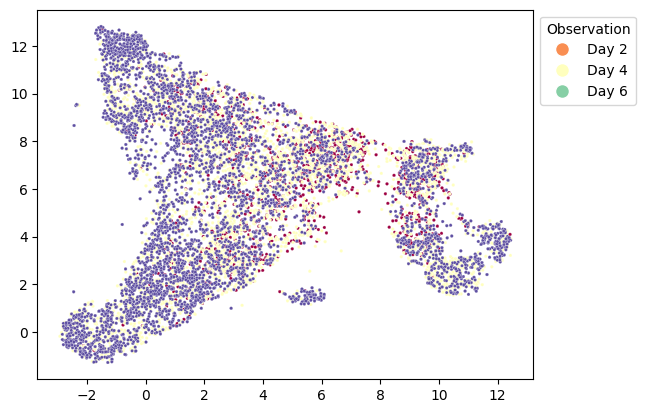

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

c_map = "Spectral" #"RdYlBu"
y = check_adata.obs['Day']
embedding_x = check_adata.obsm['umap'][:, 0]
embedding_y = check_adata.obsm['umap'][:, 1]
obs_df = pd.DataFrame(check_adata.obs)
filtered_indices = np.where(obs_df['Day'] == obs_df['initial'])[0]
filtered_embedding_x = embedding_x[filtered_indices]
filtered_embedding_y = embedding_y[filtered_indices]
filtered_y = y[filtered_indices]
cmap = plt.cm.get_cmap(c_map, len(filtered_y))
ax = sns.scatterplot(x=filtered_embedding_x, y=filtered_embedding_y, hue=filtered_y, palette=cmap, s=5)
unique_values = sorted(filtered_y.unique())
color_palette = sns.color_palette(c_map, len(unique_values))
ax.legend_.remove()


handles = [
    plt.Line2D(
        [0],
        [0],
        marker='o',
        color='w',
        markerfacecolor=color_palette[i],
        markersize=10,
        label=f'Day {unique_values[i]:.0f}'
    )
    for i in range(len(unique_values))
]

plt.legend(handles=handles, title='Observation', loc='upper left', bbox_to_anchor=(1, 1))

plt.show()


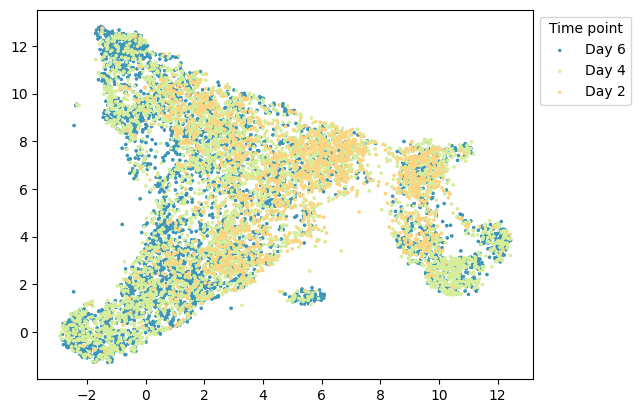

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

dot_size = 2
y = check_adata.obs['Day']
embedding_x = check_adata.obsm['umap'][:, 0]
embedding_y = check_adata.obsm['umap'][:, 1]
obs_df = pd.DataFrame(check_adata.obs)
color_mapping = {2: '#fed481', 4: '#d6ee9b', 6: '#3d95b8'}
color_mapping_face = ['#fed481', '#d6ee9b', '#3d95b8']

point_colors = [color_mapping[val] for val in y]

filtered_indices_6 = np.where(obs_df['Day'] == 6)[0]
filtered_embedding_x_6 = embedding_x[filtered_indices_6]
filtered_embedding_y_6 = embedding_y[filtered_indices_6]
filtered_y_6 = y[filtered_indices_6]

filtered_indices_4 = np.where(obs_df['Day'] == 4)[0]
filtered_embedding_x_4 = embedding_x[filtered_indices_4]
filtered_embedding_y_4 = embedding_y[filtered_indices_4]
filtered_y_4 = y[filtered_indices_4]

filtered_indices_2 = np.where(obs_df['Day'] == 2)[0]
filtered_embedding_x_2 = embedding_x[filtered_indices_2]
filtered_embedding_y_2 = embedding_y[filtered_indices_2]
filtered_y_2 = y[filtered_indices_2]

plt.scatter(filtered_embedding_x_6, filtered_embedding_y_6, c=[color_mapping[val] for val in filtered_y_6], s=dot_size, label='Day 6')
plt.scatter(filtered_embedding_x_4, filtered_embedding_y_4, c=[color_mapping[val] for val in filtered_y_4], s=dot_size, label='Day 4') #, alpha=0.5
plt.scatter(filtered_embedding_x_2, filtered_embedding_y_2, c=[color_mapping[val] for val in filtered_y_2], s=dot_size, label='Day 2') #, alpha=0.5

plt.grid(False)
plt.gca().set_facecolor('white')

legend = plt.legend(title='Time point', loc='upper left', bbox_to_anchor=(1, 1))
legend.set_frame_on(True)
legend.get_frame().set_facecolor('white')

plt.show()

### observation cell types

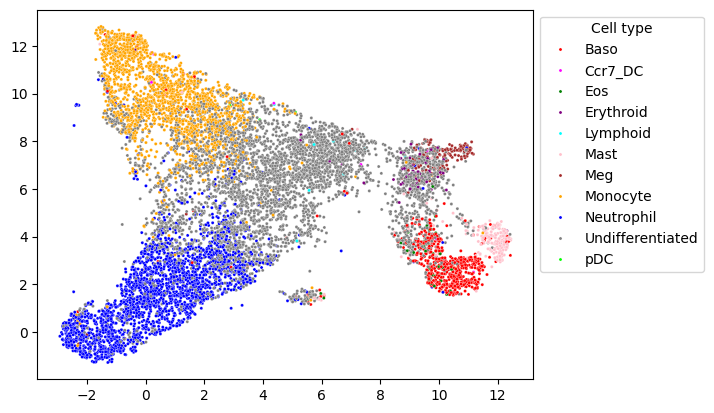

In [ ]:
import seaborn

y = check_adata.obs['Celltype']
embedding_x = check_adata.obsm['umap'][:, 0]
embedding_y = check_adata.obsm['umap'][:, 1]

custom_palette = {
    'Baso': 'red',
    'Ccr7_DC': 'magenta',
    'Eos': 'green',
    'Erythroid': 'purple',
    'Lymphoid': 'cyan',
    'Mast': 'pink',
    'Meg': 'brown',
    'Monocyte': 'orange',
    'Neutrophil': 'blue',
    'Undifferentiated': 'gray',
    'pDC': 'lime'
}


ax = seaborn.scatterplot(x=embedding_x, y=embedding_y, hue=y, palette=custom_palette, s=5)
plt.grid(False)
plt.gca().set_facecolor('white')

legend = plt.legend(title='Cell type', loc='upper left', bbox_to_anchor=(1, 1))
legend.set_frame_on(True)
legend.get_frame().set_facecolor('white')

plt.show()

In [ ]:
select_check_adata, trans = latent_visualization(select_adata, LineageVAE_exp, adata.var_names, trans=trans)
select_check_adata.write(dt_now + '_select_check_adata.h5ad')
files.download(dt_now + '_select_check_adata.h5ad')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

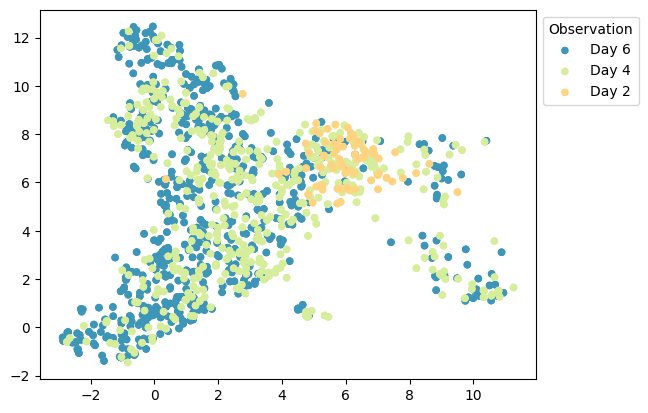

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

c_map = "Spectral"
y = select_check_adata.obs['Day']
embedding_x = select_check_adata.obsm['umap'][:, 0]
embedding_y = select_check_adata.obsm['umap'][:, 1]
obs_df = pd.DataFrame(select_check_adata.obs)

color_mapping = {2: '#fed481', 4: '#d6ee9b', 6: '#3d95b8'}
color_mapping_face = ['#fed481', '#d6ee9b', '#3d95b8']

point_colors = [color_mapping[val] for val in y]

filtered_indices_6 = np.where(obs_df['Day'] == 6)[0]
filtered_embedding_x_6 = embedding_x[filtered_indices_6]
filtered_embedding_y_6 = embedding_y[filtered_indices_6]
filtered_y_6 = y[filtered_indices_6]

filtered_indices_4 = np.where(obs_df['Day'] == 4)[0]
filtered_embedding_x_4 = embedding_x[filtered_indices_4]
filtered_embedding_y_4 = embedding_y[filtered_indices_4]
filtered_y_4 = y[filtered_indices_4]

filtered_indices_2 = np.where(obs_df['Day'] == 2)[0]
filtered_embedding_x_2 = embedding_x[filtered_indices_2]
filtered_embedding_y_2 = embedding_y[filtered_indices_2]
filtered_y_2 = y[filtered_indices_2]

plt.scatter(filtered_embedding_x_6, filtered_embedding_y_6, c=[color_mapping[val] for val in filtered_y_6], s=20, label='Day 6')


plt.scatter(filtered_embedding_x_4, filtered_embedding_y_4, c=[color_mapping[val] for val in filtered_y_4], s=20, label='Day 4') #, alpha=0.5
plt.scatter(filtered_embedding_x_2, filtered_embedding_y_2, c=[color_mapping[val] for val in filtered_y_2], s=20, label='Day 2') #, alpha=0.5

plt.legend(title='Observation', loc='upper left', bbox_to_anchor=(1, 1))

plt.show()


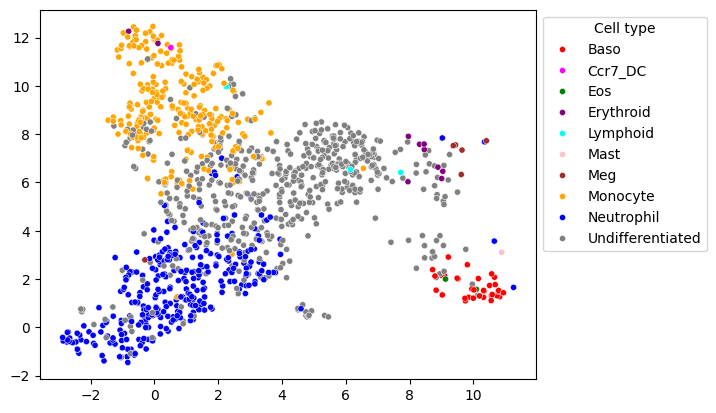

In [ ]:
import seaborn

y = select_check_adata.obs['Celltype']
embedding_x = select_check_adata.obsm['umap'][:, 0]
embedding_y = select_check_adata.obsm['umap'][:, 1]

custom_palette = {
    'Baso': 'red',
    'Ccr7_DC': 'magenta',
    'Eos': 'green',
    'Erythroid': 'purple',
    'Lymphoid': 'cyan',
    'Mast': 'pink',
    'Meg': 'brown',
    'Monocyte': 'orange',
    'Neutrophil': 'blue',
    'Undifferentiated': 'gray',
    'pDC': 'lime'
}

ax = seaborn.scatterplot(x=embedding_x, y=embedding_y, hue=y, palette=custom_palette, s=20, legend="full")
plt.grid(False)
plt.gca().set_facecolor('white')

legend = plt.legend(title='Cell type', loc='upper left', bbox_to_anchor=(1, 1))
legend.set_frame_on(True)
legend.get_frame().set_facecolor('white')

plt.show()

## Infer latent variables using learned parameters and sample the occurrence at each time

Each time you run latent_visualization(adata_6, LineageVAE_exp, adata.var_names, dynamics=True, trans=trans), a new normal distribution of latent variables is inferred using the learned parameters. From there, the Poisson distribution is decoded based on the sampled latent variables, and the expression at each time point is sampled from the distribution.

In [ ]:
def latent_transition_inferens(adata_6, LineageVAE_exp, LineageVAE_used, sigma=0.05, n_neighbors=30, min_dist=0.1, dz_var_prop=0.05, sample_num=10, dynamics=False, trans=None):

    inf_adata, trans = latent_visualization(adata_6, LineageVAE_exp, adata.var_names, dynamics=True, trans=trans) #input

    a = len(inf_adata[inf_adata.obs['Day'] == -1])
    b = int(len(inf_adata.obs) / a)
    inf_adata.obs['CellID'] = None
    for i in range(b):
        start_idx = i * a
        end_idx = (i + 1) * a
        inf_adata.obs['CellID'][start_idx:end_idx] = inf_adata[inf_adata.obs['Day'] == -1].obs.index

    return inf_adata, trans

In [ ]:
import anndata
from google.colab import files
import datetime

#total
#adata_6 = sc.read("20230413_total_adata.h5ad", cache=True) # if you want to use all cells
adata_6 = select_adata # when you use only select data
adata_6 = adata_6[adata_6.obs['Day']==6]
adata_6 = adata_6[:,var_list]

dt_now = datetime.datetime.now().strftime('%Y%m%d%H%M')
#inf_adata, trans = latent_visualization(select_adata[select_adata.obs['Day']==28], LineageVAE_exp, adata.var_names, dynamics=True, trans=trans) #input
inf_adata, trans = latent_transition_inferens(adata_6, LineageVAE_exp, adata.var_names, dynamics=True, trans=trans) #input

In [ ]:
inf_adata.obs.index = inf_adata.obs['CellID']
inf_adata.obs.index.name = 'CellID_index'
inf_adata.write(dt_now + '_inf_adata.h5ad')
files.download(dt_now + '_inf_adata.h5ad')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
from scipy.sparse import csc_matrix

def sparse_matrix_to_csv(sparse_matrix, filename):
    # Convert the sparse matrix to a dense array
    dense_array = csc_matrix(sparse_matrix).toarray()

    # Create a DataFrame from the dense array
    df = pd.DataFrame(dense_array)

    # Save the DataFrame to a CSV file
    df.to_csv(filename, index=False)

    return df


dt_now = datetime.datetime.now().strftime('%Y%m%d%H%M')
input_sparse_matrix = inf_adata.X
csv_filename = dt_now + '_dense_matrix.csv'
dense_df = sparse_matrix_to_csv(input_sparse_matrix, csv_filename)
dense_df

In [ ]:
import pandas as pd

duplicates = dense_df.duplicated(keep=False)
duplicates_with_same_sequence = dense_df[duplicates]

if not duplicates_with_same_sequence.empty:
    print("Rows with the same number sequence:")
    print(duplicates_with_same_sequence)
else:
    print("No rows with the same number sequence found.")


In [ ]:
columns_with_same_order = []

for col1 in dense_df.columns:
    for col2 in dense_df.columns:
        if col1 != col2:
            if (dense_df[col1] == dense_df[col2]).all():
                columns_with_same_order.append((col1, col2))

if columns_with_same_order:
    print("Columns with the same vertical number order:")
    for cols in columns_with_same_order:
        print(f"{cols[0]} and {cols[1]}")
else:
    print("No columns with the same vertical number order.")

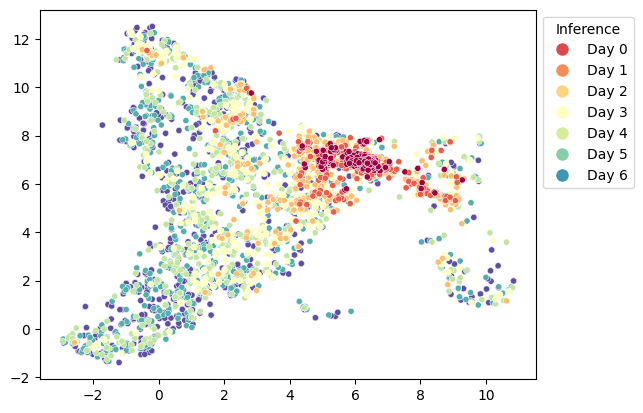

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

c_map = "Spectral" #"RdYlBu"
filtered_indices = inf_adata.obs['Day'] > -1
filtered_embedding_x = inf_adata.obsm['umap'][filtered_indices, 0]
filtered_embedding_y = inf_adata.obsm['umap'][filtered_indices, 1]
filtered_y = inf_adata.obs['Day'][filtered_indices]

ax = sns.scatterplot(x=filtered_embedding_x, y=filtered_embedding_y, hue=filtered_y, palette=c_map, s=20)
ax.legend_.remove()

unique_values = sorted(filtered_y.unique())
color_palette = sns.color_palette(c_map, len(unique_values))
color_list = [sns.color_palette(c_map, len(unique_values)).as_hex()[i] for i in range(len(unique_values))] #for embed check

handles = [
    plt.Line2D(
        [0],
        [0],
        marker='o',
        color='w',
        markerfacecolor=color_palette[i],
        markersize=10,
        label=f'Day {unique_values[i]:.0f}'
    )
    for i in range(len(unique_values))
]

plt.legend(handles=handles, title='Inference', loc='upper left', bbox_to_anchor=(1, 1))

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

unique_days = np.unique(inf_adata.obs['Day'])
unique_days = unique_days[unique_days != -1]

c_map = "Spectral"
color_palette = sns.color_palette(c_map, len(unique_days))

for i in unique_days:
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.set_facecolor('white')
    umap_coords = inf_adata.obsm['umap']
    ax.scatter(umap_coords[:, 0], umap_coords[:, 1], color='grey', s=10)

    adata_subset = inf_adata[inf_adata.obs['Day'] == i]
    umap_coords_subset = adata_subset.obsm['umap']

    ax.scatter(umap_coords_subset[:, 0], umap_coords_subset[:, 1], s=10, cmap='viridis', color=color_palette[i])
    ax.set_title(f"Day {i}")
    ax.grid(False)
    plt.show()


In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

max_day = max(inf_adata.obs['Day'])
z_ranges = []

for i in range(max_day + 1):
    subset_data = inf_adata[inf_adata.obs['Day'] == i].obsm['z']
    mean = np.mean(subset_data, axis=0)  # Calculate the mean for each of the 10 dimensions
    variance = np.var(subset_data, axis=0)  # Calculate the variance for each of the 10 dimensions
    z_ranges.append((mean, variance))

confidence_intervals = []

for i in range(max_day + 1):
    mean, variance = z_ranges[i]
    n = len(inf_adata[inf_adata.obs['Day'] == i])
    alpha = 0.05  # 95% confidence level

    # Calculate the standard error of the mean
    sem = np.sqrt(variance / n)

    # Calculate the margin of error
    margin_error = stats.t.ppf(1 - alpha / 2, n - 1) * sem

    # Calculate the confidence interval
    lower_bound = mean - margin_error
    upper_bound = mean + margin_error

    confidence_intervals.append((lower_bound, upper_bound))


In [ ]:
import csv

# Define the file path where you want to save the CSV file
dt_now = datetime.datetime.now().strftime('%Y%m%d%H%M')
csv_file_path = dt_now + "_z_ranges_data.csv"

# Open the CSV file for writing
with open(csv_file_path, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)

    # Write the header row with column names
    writer.writerow(["Dimension", "Means", "Variances"])

    # Iterate through the z_ranges and write the data for each dimension
    for i, (means, variances) in enumerate(z_ranges):
        writer.writerow([i, means.tolist(), variances.tolist()])

print(f"Data saved as {csv_file_path}")


# Reconstruction of historical expression

## Confirm inference results based on marker gene expression

### Classifying Cells Based on Differentiation Direction

The function `main_differentiation_destination` is designed to classify cells based on their differentiation direction. By grouping cells, it simplifies the analysis and helps to identify cells with similar expression profiles, facilitating downstream analysis. Here is a step-by-step explanation of the code:

1. **Function Definition**:
   - The function takes three arguments:
     - `adata`: An AnnData object containing single-cell data.
     - `dif_ratio`: A threshold ratio to determine the main differentiation destination.
     - `timepoint` (optional): A specific time point for inferring differentiation.

2. **Extract Unique Lineages**:
   - The unique lineages in the dataset are extracted from the `Lineage` column in `adata.obs`.

3. **Iterate Through Each Lineage**:
   - For each lineage, the initial `main_differentiation_destination` is set to 'Undifferentiated'.
   - A subset of the data for the current lineage is created.

4. **Determine Main Differentiation Destination**:
   - If there are non-undifferentiated cells at Day 6, the function iterates through the unique cell types, excluding 'Undifferentiated'.
   - For each cell type, it calculates the ratio of cells that differentiate into that type.
   - If the ratio exceeds `dif_ratio`, the cell type is set as the `main_differentiation_destination`.

5. **Update `main_differentiation_destination` in AnnData**:
   - If `timepoint` is provided, the main differentiation destination is updated for cells at that specific time point within the lineage.
   - If `timepoint` is not provided, it updates the `main_differentiation_destination` for all cells within the lineage.

6. **Return the Updated AnnData Object**:
   - The function returns the updated AnnData object with the `main_differentiation_destination` column added to `adata.obs`.

This classification helps group similar expression profile cells, making it easier to analyze their differentiation paths and identify key characteristics associated with different cell types.


In [ ]:
inf_adata, trans = latent_transition_inferens(adata_6, LineageVAE_exp, adata.var_names, dynamics=True, trans=trans) #input

In [ ]:
import anndata as ad

def main_differentiation_destination(adata, dif_ratio, timepoint=None):
    lineage_list = adata.obs['Lineage'].unique()
    for lineage in lineage_list:
        main_differentiation_destination = 'Undifferentiated'
        a_subset = adata[(adata.obs['Lineage'] == lineage)]
        a_day6 = a_subset[a_subset.obs['Day'] == 6]

        # Count the number of cells that are not 'Undifferentiated' at Day 6
        a_day6_not_undiff = a_day6[a_day6.obs['Celltype'] != 'Undifferentiated']
        a = a_day6_not_undiff.shape[0]

        if a != 0:
            celltype_list = adata.obs['Celltype'].unique()
            celltype_list = [x for x in celltype_list if x != 'Undifferentiated']
            for celltype in celltype_list:
                b = a_day6[a_day6.obs['Celltype'] == celltype].shape[0]
                if b/a > dif_ratio:
                    main_differentiation_destination = celltype

            if timepoint is not None:
                adata.obs.loc[(adata.obs['Lineage'] == lineage) & (adata.obs['inference'] == timepoint), 'main_differentiation_destination'] = main_differentiation_destination
            else:
                adata.obs.loc[adata.obs['Lineage'] == lineage, 'main_differentiation_destination'] = main_differentiation_destination

    return adata

In [ ]:
import scanpy as sc
import pandas as pd
#markers = ['Aff3', 'Rnf149', 'Slc40a1']
PanglaoDB = pd.read_csv('PanglaoDB.csv')
PanglaoDB = PanglaoDB.dropna(how='all').dropna(how='all', axis=1)

In [ ]:
import scanpy as sc
import pandas as pd

cell_type_mapping = {
    'Baso': 'Basophils',
    'Eos': 'Eosinophils',
    'Mast': 'Mast cells',
    'Meg': 'Megakaryocytes',
    'Monocyte': 'Monocytes',
    'Neutrophil': 'Neutrophils',
    'Undifferentiated': 'Hematopoietic stem cells'
}

cell_types = inf_adata.obs['differentiation_destination'].unique()

all_plots = []

for cell_type in cell_types:
    full_cell_type_name = cell_type_mapping.get(cell_type, cell_type)

    cell_type_markers = PanglaoDB['gene_names'][(PanglaoDB['cell type'] == full_cell_type_name)].tolist()
    cell_type_markers = list(set(inf_adata.var_names).intersection(set(cell_type_markers)))

    if not cell_type_markers:
        continue

    inf_adata_subset = inf_adata[inf_adata.obs['differentiation_destination'] == cell_type][:, cell_type_markers]
    inf_adata_subset = inf_adata_subset[inf_adata_subset.obs['reconst']==1] #reconst
    sc.pp.scale(inf_adata_subset, zero_center=True, max_value=1)
    plot = sc.pl.matrixplot(inf_adata_subset, cell_type_markers, groupby='Day', show=False, cmap='viridis', swap_axes=True, title='Cell Type: {}'.format(full_cell_type_name))

    all_plots.append(plot)

for cell_type in cell_types:

    full_cell_type_name = cell_type_mapping.get(cell_type, cell_type)

    undifferentiated_markers = PanglaoDB['gene_names'][(PanglaoDB['cell type'] == 'Hematopoietic stem cells')].tolist()
    undifferentiated_markers = list(set(inf_adata.var_names).intersection(set(undifferentiated_markers)))

    if not undifferentiated_markers:
        continue

    inf_adata_subset = inf_adata[inf_adata.obs['differentiation_destination'] == cell_type][:, undifferentiated_markers]
    inf_adata_subset = inf_adata_subset[inf_adata_subset.obs['reconst']==1] #reconst
    sc.pp.scale(inf_adata_subset, zero_center=True, max_value=1)

    plot = sc.pl.matrixplot(inf_adata_subset, undifferentiated_markers, groupby='Day', show=False, cmap='viridis', swap_axes=True, title='Cell Type: {}'.format(full_cell_type_name))

    all_plots.append(plot)


In [ ]:
import scanpy as sc
sc.pl.umap(inf_adata, color=['Ngp', 'Psap', 'Cd34'], size=100, cmap='viridis')

In [ ]:
import matplotlib.pyplot as plt

days = np.unique(inf_adata.obs['Day'])
days = days[days >= 0]

genes_of_interest = ['Ngp', 'Psap', 'Cd34']

for i in days:
    adata_subset = inf_adata[inf_adata.obs['Day'] == i, :]

    for gene_of_interest in genes_of_interest:
        fig = plt.figure(figsize=(6, 4))
        umap_coords = inf_adata.obsm['umap']
        plt.scatter(umap_coords[:, 0], umap_coords[:, 1], color='grey', s=10)

        umap_coords_subset = adata_subset.obsm['umap']
        c_values = adata_subset[:, gene_of_interest].X.A  # Convert to NumPy array
        c_values = np.log1p(c_values)

        plt.scatter(umap_coords_subset[:, 0], umap_coords_subset[:, 1], c=c_values, s=10, cmap='viridis')

        plt.title(f"Day {i}, Gene: {gene_of_interest}")
        plt.grid(False)
        plt.gca().set_facecolor('white')

        plt.show()


# Compare with other methods

In [ ]:
inf_adata_5 = inf_adata[(inf_adata.obs['Day'] != 6) | (inf_adata.obs['reconst'] != 1)]
check_adata = check_adata[(check_adata.obs['Day'] != 6) | (check_adata.obs['reconst'] != 1)]

In [ ]:
import scvelo as scv

#direction_adata = check_adata[select_adata.obs_names,:]
direction_adata = select_adata.copy()
direction_adata.obsm['umap'] = select_check_adata[select_check_adata.obs['reconst']==0].obsm['umap']
direction_adata.obsm['z'] = select_check_adata[select_check_adata.obs['reconst']==0].obsm['z']
sc.tl.pca(direction_adata)
sc.pp.neighbors(direction_adata, n_pcs=30, n_neighbors=30, random_state=0)
sc.tl.diffmap(direction_adata)
root_idx = np.random.choice(np.where(direction_adata[direction_adata.obs["Celltype"] == "Undifferentiated"].obs["Day"] == 2)[0])
direction_adata.uns["iroot"] = root_idx
sc.tl.dpt(direction_adata)

In [ ]:
direction_adata.write_h5ad(dt_now + "_direction_adata.h5ad")

Normalized count data: X, spliced, unspliced.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 2/2 cores)


  0%|          | 0/514 [00:00<?, ?gene/s]

    finished (0:02:03) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/2 cores)


  0%|          | 0/1180 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
Renamed 'umap' to convention 'X_umap' (adata.obsm).
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


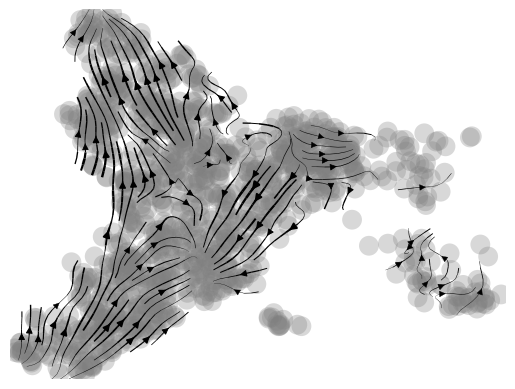

computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


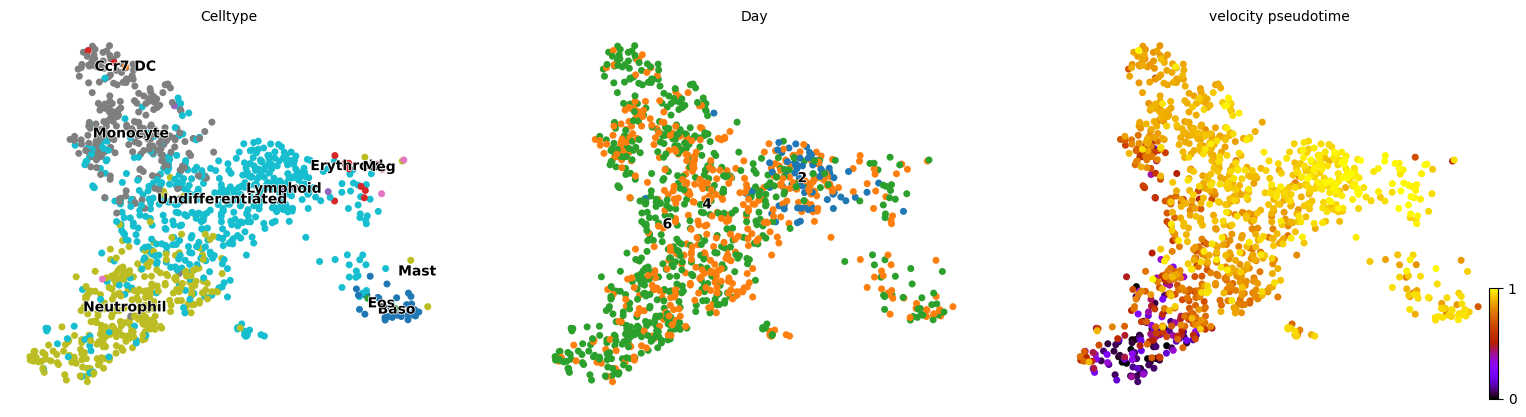

In [ ]:
scv.pp.moments(direction_adata, n_pcs=None, n_neighbors=None)
scv.tl.recover_dynamics(direction_adata, n_jobs=8)
scv.tl.velocity(direction_adata, mode="dynamical")
scv.tl.velocity_graph(direction_adata)
scv.pl.velocity_embedding_stream(direction_adata, basis="umap", legend_fontsize=12, title="", smooth=0.8, min_mass=4)
scv.tl.velocity_pseudotime(direction_adata)
scv.tl.latent_time(direction_adata)
scv.pl.scatter(direction_adata, color=['Celltype', 'Day', 'velocity_pseudotime'], cmap='gnuplot', legend_loc='on data')

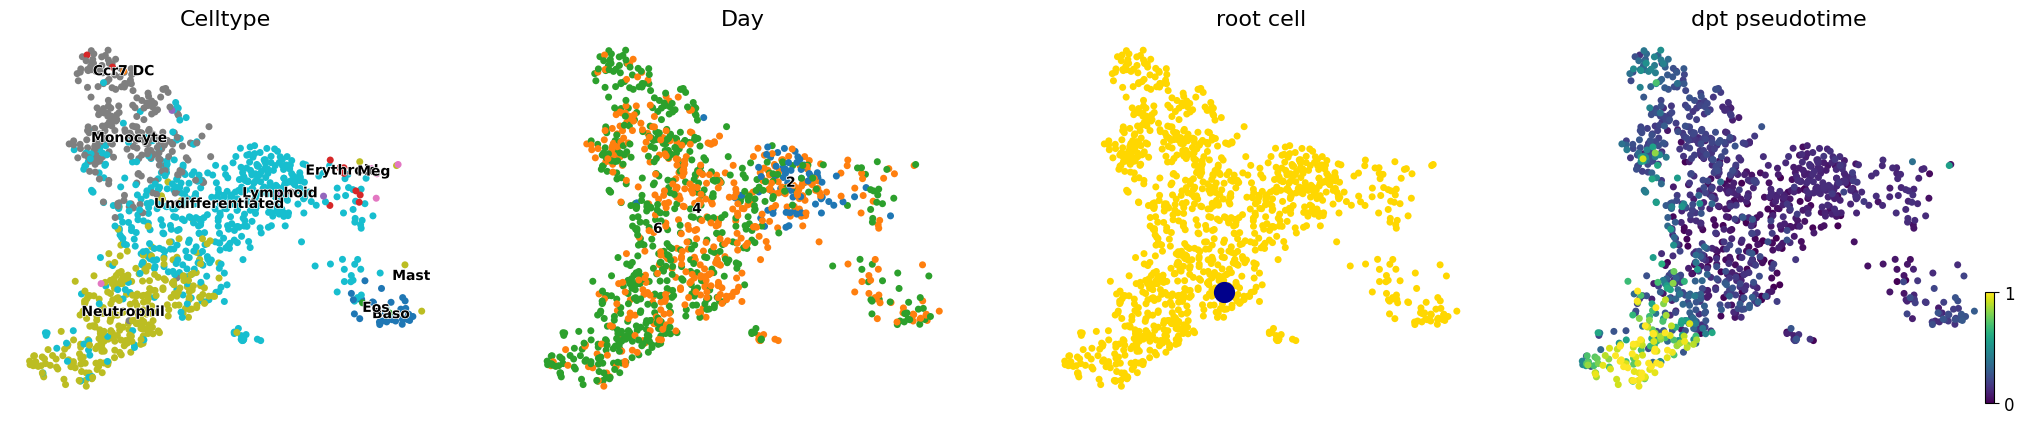

In [ ]:
import scvelo as scv

scv.pl.scatter(
    direction_adata,
    color=["Celltype", 'Day', root_idx, "dpt_pseudotime"],
    fontsize=16,
    cmap="viridis",
    perc=[2, 98],
    colorbar=True,
    rescale_color=[0, 1],
    title=["Celltype", 'Day', "root cell", "dpt pseudotime"],
    legend_loc='on data',
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-42-34ca98ea0f33>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_reversed = plt.cm.get_cmap("Spectral")


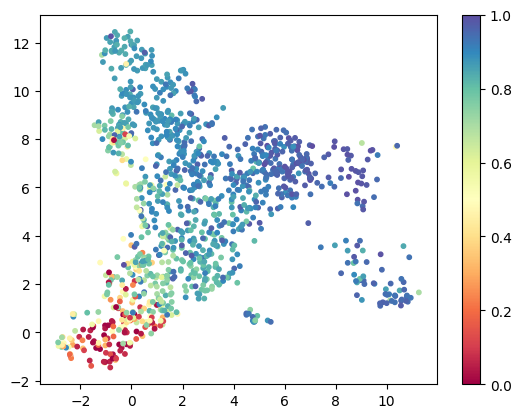

In [ ]:
import matplotlib.pyplot as plt

x = direction_adata.obsm['umap'][:,0]
y = direction_adata.obsm['umap'][:,1]
colors = direction_adata.obs['velocity_pseudotime']
cmap_reversed = plt.cm.get_cmap("Spectral")


plt.scatter(x, y, c=colors, cmap=cmap_reversed, s=10)
plt.grid(False)
plt.gca().set_facecolor('white')
plt.colorbar()
plt.show()

<ipython-input-43-94c1617cc659>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_reversed = plt.cm.get_cmap("Spectral") #.reversed()


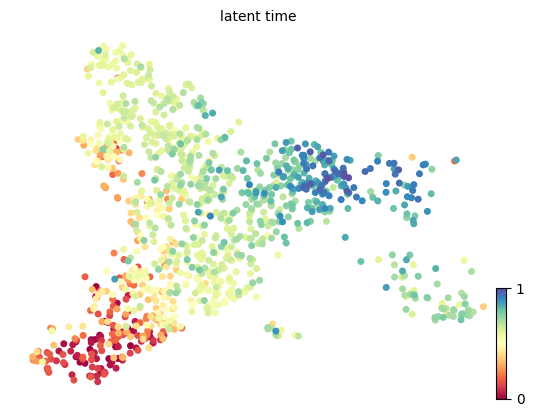

In [ ]:
import matplotlib.pyplot as plt

# Get the 'bwr' colormap and reverse it
cmap_reversed = plt.cm.get_cmap("Spectral") #.reversed()
# Use the reversed colormap in the scv.pl.scatter function
scv.pl.scatter(direction_adata, color=['latent_time'], cmap=cmap_reversed, legend_loc='on data')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-44-fb6b7d4c39ae>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_reversed = plt.cm.get_cmap("Spectral") #.reversed()


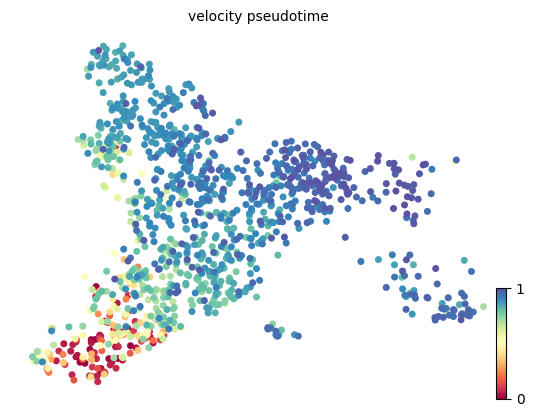

In [ ]:
import matplotlib.pyplot as plt

# Get the 'bwr' colormap and reverse it
cmap_reversed = plt.cm.get_cmap("Spectral") #.reversed()
# Use the reversed colormap in the scv.pl.scatter function
scv.pl.scatter(direction_adata, color=['velocity_pseudotime'], cmap=cmap_reversed, legend_loc='on data')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-45-52937e4213e2>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_reversed = plt.cm.get_cmap("Spectral")


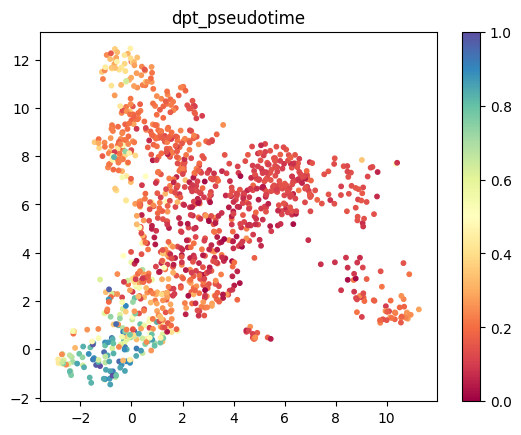

In [ ]:
import matplotlib.pyplot as plt

x = direction_adata.obsm['umap'][:,0]
y = direction_adata.obsm['umap'][:,1]
colors = direction_adata.obs['dpt_pseudotime']
cmap_reversed = plt.cm.get_cmap("Spectral")

plt.title('dpt_pseudotime')
plt.scatter(x, y, c=colors, cmap=cmap_reversed, s=10)
plt.grid(False)
plt.gca().set_facecolor('white')
plt.colorbar()
plt.show()

<ipython-input-46-16ba48ccddf6>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_reversed = plt.cm.get_cmap('Spectral') #.reversed()


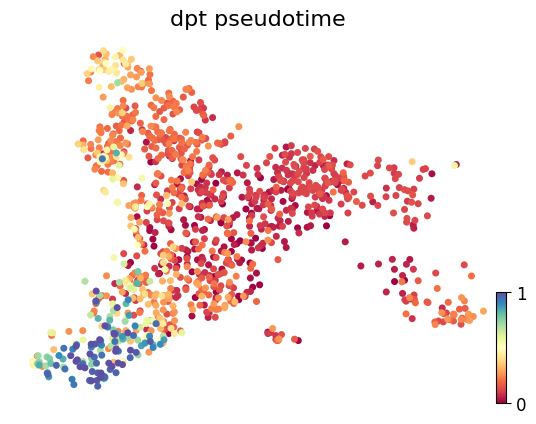

In [ ]:
import matplotlib.pyplot as plt

# Get the 'bwr' colormap and reverse it
cmap_reversed = plt.cm.get_cmap('Spectral') #.reversed()

scv.pl.scatter(
    direction_adata,
    color=['dpt_pseudotime'],
    fontsize=16,
    cmap=cmap_reversed,
    perc=[2, 98],
    colorbar=True,
    rescale_color=[0, 1],
    title=['dpt_pseudotime'],
    legend_loc='on data',
)

In [ ]:
import pandas as pd


def find_rootcell(inf_adata, direction_adata, order):

    sorted_df = direction_adata.obs.sort_values(by=order)
    for cell_id, dpt_pseudotime in sorted_df.iterrows():
        cell_id = cell_id + "-1"
        if cell_id in inf_adata.obs['CellID'].values:
            return cell_id
            break

rootcell_name = find_rootcell(inf_adata, direction_adata, 'dpt_pseudotime')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#pseudo0z = inf_adata.obsm['z'][inf_adata.obs['CellID'] == direction_adata.obs.index[direction_adata.obs['dpt_pseudotime'] == 0][0]][0]
#velocity0z = inf_adata.obsm['z'][inf_adata.obs['CellID'] == direction_adata.obs.index[direction_adata.obs['velocity_pseudotime'] == 0][0]][0]
rootcell_name = find_rootcell(inf_adata, direction_adata, 'dpt_pseudotime')
pseudo0z = inf_adata.obsm['z'][inf_adata.obs['CellID'] == rootcell_name][0]
rootcell_name = find_rootcell(inf_adata, direction_adata, 'latent_time')
velocity0z = inf_adata.obsm['z'][inf_adata.obs['CellID'] == rootcell_name][0]
inf0z = inf_adata.obsm['z'][(inf_adata.obs['Day'] == 0) & (inf_adata.obs['initial'] == 6)]
inf0z = np.mean(inf0z, axis=0)
obs2z = check_adata.obsm['z'][(check_adata.obs['initial'] == 2)]
obs2z = np.mean(obs2z, axis=0)
euclidean_distance_pseudo = np.linalg.norm(obs2z - pseudo0z)
euclidean_distance_velocity = np.linalg.norm(obs2z - velocity0z)
euclidean_distance_lineage = np.linalg.norm(obs2z - inf0z)


import pandas as pd

data = {
    'Method': ['Pseudotime', 'scVelo', 'LineageVI'],
    'Euclidean Distance': [euclidean_distance_pseudo, euclidean_distance_velocity, euclidean_distance_lineage]
}
df = pd.DataFrame(data)
print('Euclidean distance between the rootcell and day2 (the most undifferentiated observed cell) for each method')
print(df)


# Analyze progenitor expression bias

In [ ]:
def main_differentiation_destination(inf_adata, dif_ratio, timepoint=None):
    lineage_list = inf_adata.obs['Lineage'].unique().tolist()
    for lineage in lineage_list:
        main_differentiation_destination = 'Undifferentiated'
        inf_adata.obs.loc[(inf_adata.obs['Lineage'] == lineage), 'main_differentiation_destination'] = main_differentiation_destination
        a = inf_adata.obs[(inf_adata.obs['Lineage'] == lineage) & (inf_adata.obs['Day'] == 6) & ~(inf_adata.obs['Celltype'] == 'Undifferentiated')].shape[0]
        if a != 0:
            celltype_list = inf_adata.obs['Celltype'].unique().tolist()
            celltype_list = [str(x) for x in celltype_list]
            celltype_list = [x for x in celltype_list if x != 'nan']
            for celltype in celltype_list:
                b = inf_adata.obs[(inf_adata.obs['Lineage'] == lineage) & (inf_adata.obs['Day'] == 6) & (inf_adata.obs['Celltype'] == celltype)].shape[0]
                if b/a > dif_ratio:
                    main_differentiation_destination = celltype
            if timepoint is not None:
                inf_adata.obs.loc[(inf_adata.obs['Lineage'] == lineage) & (inf_adata.obs['inference'] == timepoint), 'main_differentiation_destination'] = main_differentiation_destination
            else:
                inf_adata.obs.loc[inf_adata.obs['Lineage'] == lineage, 'main_differentiation_destination'] = main_differentiation_destination
    return(inf_adata)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Confirming Expression Differences Between Cell Types and Their Ancestors

The following code aims to confirm the expression differences due to the observed expression of each cell type after differentiation and their ancestors, as well as the differences in expression due to the future cells at the early stage of differentiation. This helps to understand the gene expression changes during the differentiation process.

#### Step-by-Step Explanation:


1. **Filter Data for Day 1**:
   - `inf_adata_day1` is created by filtering `inf_adata` to include only cells from Day 0 (early differentiation stage) and cells marked as reconstructed (`reconst == 1`).
   - Further filter to include only cells with `main_differentiation_destination` as either 'Monocyte' or 'Neutrophil'.

2. **Ensure Valid Groups**:
   - Identify valid groups where the number of cells is greater than 1.
   - Filter `inf_adata_day1` to keep only valid groups.

3. **Scale Data**:
   - Scale the data to have zero mean and unit variance. The maximum value for scaling is set to 1.

4. **Rank Genes Using Wilcoxon Test**:
   - Perform differential expression analysis using the Wilcoxon rank-sum test.
   - The analysis is grouped by `main_differentiation_destination`, and the results are added to the AnnData object under the key 'wilcoxon'.

5. **Visualize Gene Expression Differences**:
   - Plot a heatmap of the top 10 differentially expressed genes between the groups.
   - The heatmap shows the scaled expression values with a color map 'viridis'.
   - Display the heatmap using `plt.show()`.

The following code achieves the above steps:


In [ ]:
inf_adata = main_differentiation_destination(inf_adata, 0.4)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


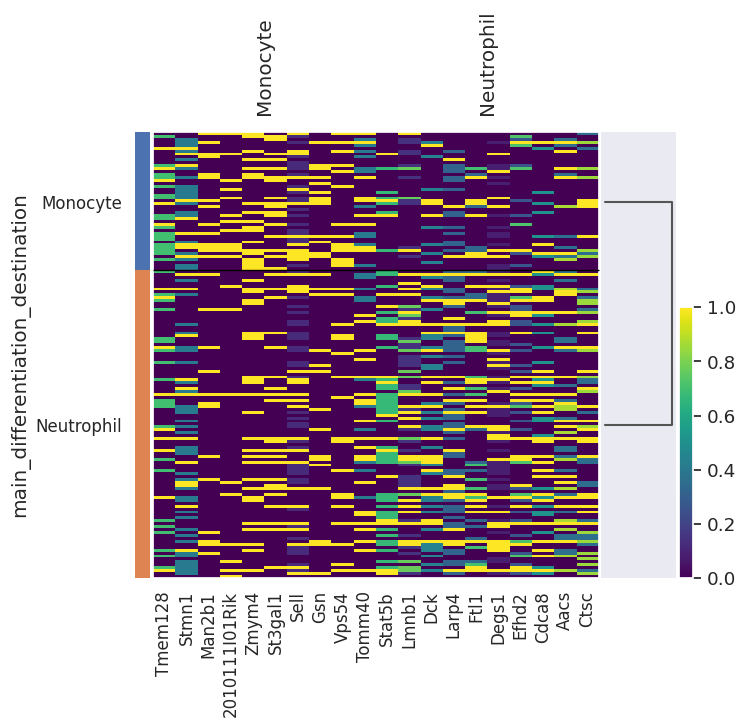

In [ ]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt


inf_adata_day1 = inf_adata[(inf_adata.obs['Day'] == 0) & (inf_adata.obs['reconst'] == 1)].copy()
inf_adata_day1 = inf_adata_day1[
    (inf_adata_day1.obs['main_differentiation_destination'] == 'Monocyte') |
    (inf_adata_day1.obs['main_differentiation_destination'] == 'Neutrophil')
]


valid_groups = [group for group in inf_adata_day1.obs['main_differentiation_destination'].unique() if (inf_adata_day1.obs['main_differentiation_destination'] == group).sum() > 1]
inf_adata_day1 = inf_adata_day1[inf_adata_day1.obs['main_differentiation_destination'].isin(valid_groups)]

sc.pp.scale(inf_adata_day1, zero_center=True, max_value=1)


sc.tl.rank_genes_groups(inf_adata_day1, groupby='main_differentiation_destination', method='wilcoxon', key_added='wilcoxon')


sc.pl.rank_genes_groups_heatmap(
    inf_adata_day1,
    n_genes=10,
    key='wilcoxon',
    groupby='main_differentiation_destination',
    show_gene_labels=True,
    vmin=0,
    vmax=1,
    cmap='viridis'
)


plt.show()


In [ ]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def differential_expression(adata, day_value, reconst_value, cell_types=None, n_genes=10, cmap='viridis'):

    inf_adata_day = adata[(adata.obs['Day'] == day_value) & (adata.obs['reconst'] == reconst_value)].copy()

    if cell_types:
        inf_adata_day = inf_adata_day[inf_adata_day.obs['main_differentiation_destination'].isin(cell_types)]

    valid_groups = [group for group in inf_adata_day.obs['main_differentiation_destination'].unique() if (inf_adata_day.obs['main_differentiation_destination'] == group).sum() > 1]
    inf_adata_day = inf_adata_day[inf_adata_day.obs['main_differentiation_destination'].isin(valid_groups)]

    sc.pp.scale(inf_adata_day, zero_center=True, max_value=1)

    key = 'wilcoxon'
    if key not in inf_adata_day.uns:
        sc.tl.rank_genes_groups(inf_adata_day, groupby='main_differentiation_destination', method='wilcoxon', key_added=key)

    ranked_genes_df = sc.get.rank_genes_groups_df(inf_adata_day, key=key, group=None)

    top_genes = ranked_genes_df.groupby('group').head(n_genes)

    top_gene_names = top_genes['names'].unique()

    top_genes_matrix = inf_adata_day[:, top_gene_names].X

    cd34_expression = inf_adata_day[:, 'Cd34'].X

    if isinstance(top_genes_matrix, np.ndarray):
        cd34_expression = cd34_expression.toarray().flatten()

    cd34_expression_scaled = (cd34_expression - np.min(cd34_expression)) / (np.max(cd34_expression) - np.min(cd34_expression))

    final_matrix = np.hstack((top_genes_matrix, cd34_expression_scaled[:, np.newaxis]))

    genes_list = list(top_gene_names) + ['Cd34']
    final_df = pd.DataFrame(final_matrix, columns=genes_list)
    final_df['destination'] = inf_adata_day.obs['main_differentiation_destination'].tolist()
    sorted_df = final_df.sort_values(by='destination')
    sorted_final_df = sorted_df.drop(columns='destination')

    plt.figure(figsize=(10, 8))
    sns.heatmap(sorted_final_df, cmap=cmap, vmin=0, vmax=1, yticklabels=False)
    plt.yticks([])
    cell_types_str = ' and '.join(cell_types)
    plt.title(f'Comparison of {cell_types_str} at Day {day_value}', fontsize=16)
    plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


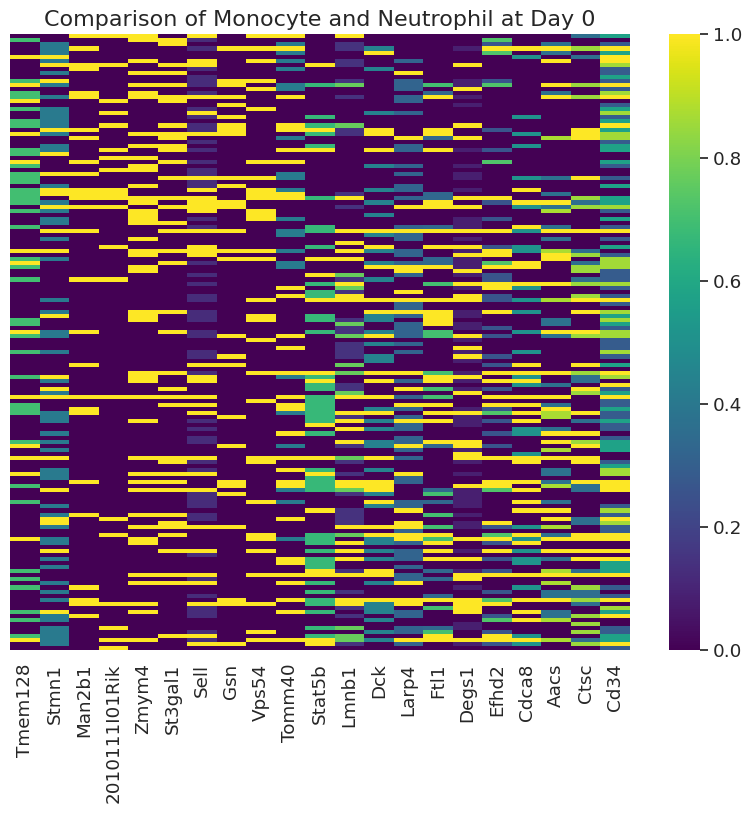

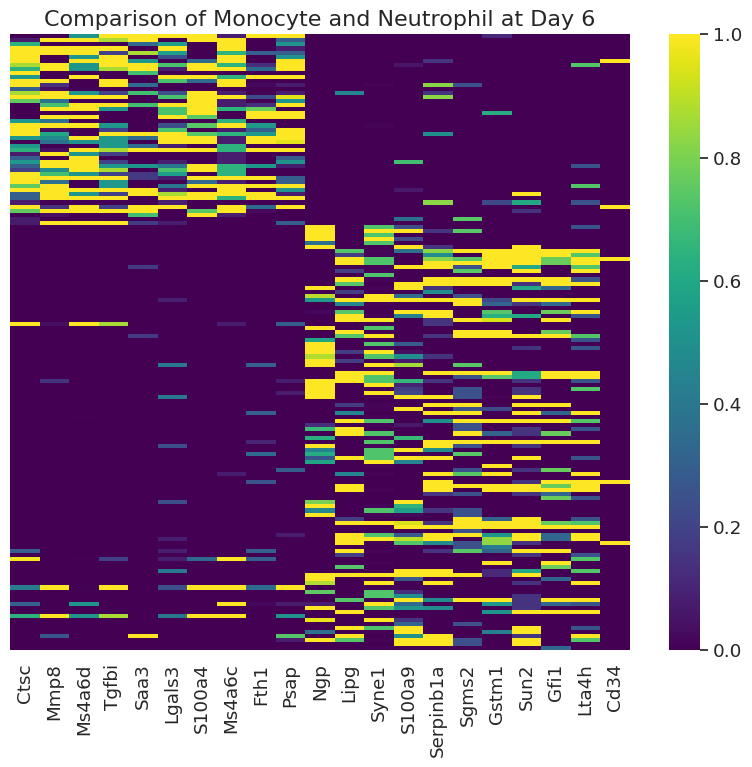

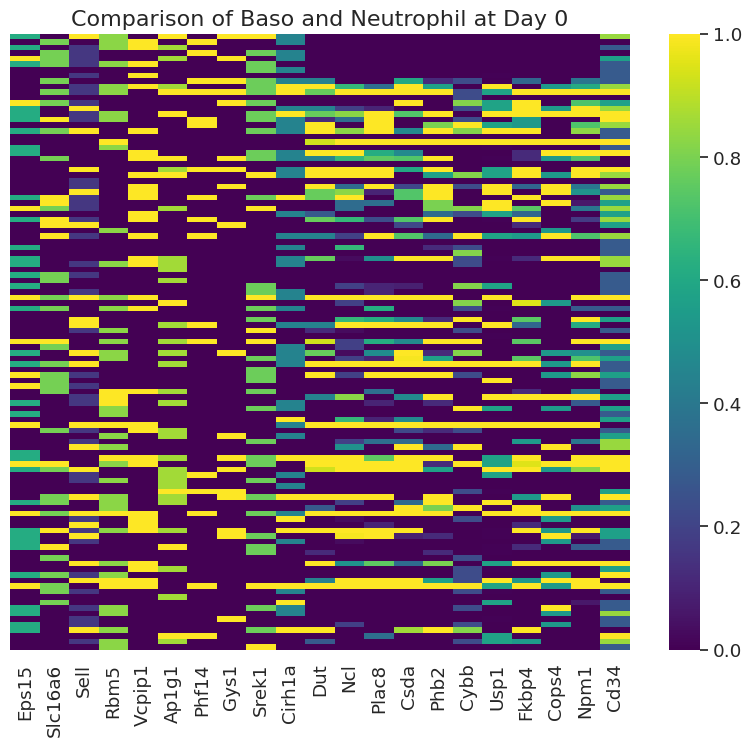

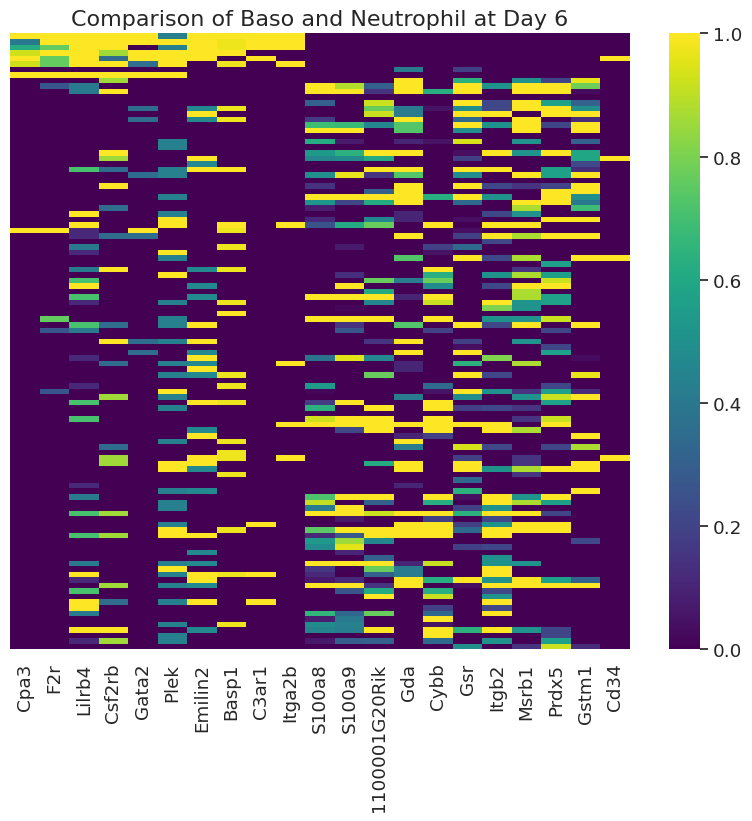

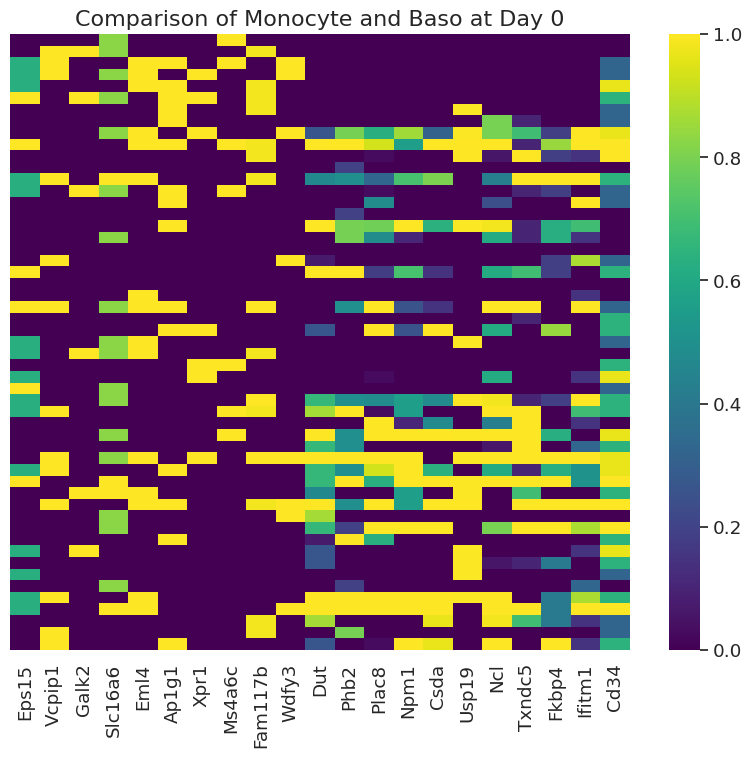

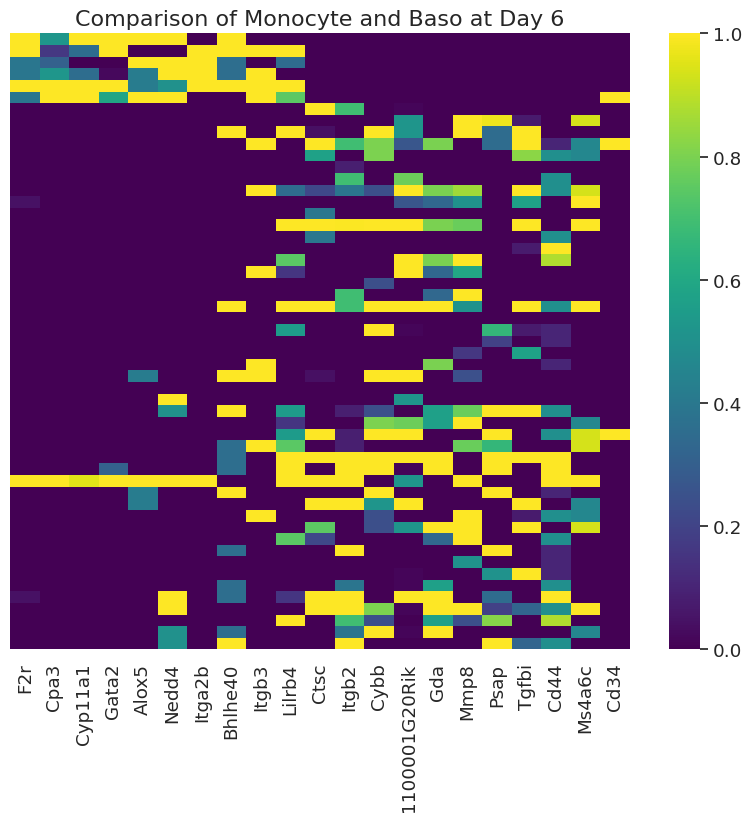

In [ ]:
combinations = [
    (0, 1, ['Monocyte', 'Neutrophil']),
    (6, 0, ['Monocyte', 'Neutrophil']),
    (0, 1, ['Baso', 'Neutrophil']),
    (6, 0, ['Baso', 'Neutrophil']),
    (0, 1, ['Monocyte', 'Baso']),
    (6, 0, ['Monocyte', 'Baso'])
]

for day_value, reconst_value, cell_types in combinations:
    differential_expression(inf_adata, day_value, reconst_value, cell_types)
